# Download Wide Field Slittless Spectroscopy (WFSS) Data
This notebook uses the python [astroquery.mast Observations](https://astroquery.readthedocs.io/en/latest/mast/mast_obsquery.html) class of the [MAST API](https://mast.stsci.edu/api/v0/) to query specific data products of a specific program. We are looking for NIRISS imaging and WFSS files of the [NGDEEP program](https://www.stsci.edu/jwst/phase2-public/2079.pdf) (ID 2079). The observations are in three [NIRISS filters](https://jwst-docs.stsci.edu/jwst-near-infrared-imager-and-slitless-spectrograph/niriss-instrumentation/niriss-pupil-and-filter-wheels): F115W, F150W, and F200W using both GR150R and GR150C [grisms](https://jwst-docs.stsci.edu/jwst-near-infrared-imager-and-slitless-spectrograph/niriss-instrumentation/niriss-gr150-grisms). A [WFSS observation sequence](https://jwst-docs.stsci.edu/jwst-near-infrared-imager-and-slitless-spectrograph/niriss-observing-strategies/niriss-wfss-recommended-strategies) typically consists of a direct image followed by a grism observation in the same blocking filter to help identify the sources in the field. In program 2079, the exposure sequence follows the pattern: direct image -> GR150R -> direct image -> GR150C -> direct image.

**Use case**: use MAST to download data products.<br>
**Data**: JWST/NIRISS images and spectra from program 2079 observation 004.<br>
**Tools**: astropy, astroquery, glob, matplotlib, numpy, os, pandas, (yaml)<br>
**Cross-instrument**: all<br>

**Content**
- [Imports](#imports)
- [Querying for Observations](#setup)
  - [Search with Proposal ID](#propid)
  - [Search with Observation ID](#obsid)
- [Filter and Download Products](#filter)
  - [Filtering Data Before Downloading](#filter_data)
  - [Downloading Data](#downloading)
- [Inspect Downloaded Data](#inspect)


**Author**: Camilla Pacifici (cpacifici@stsci.edu) & Rachel Plesha (rplesha@stsci.edu) & Jo Taylor (jotaylor@stsci.edu)<br>
**First Published**: May 2024

This notebook was inspired by the [JWebbinar session about MAST](https://github.com/spacetelescope/jwebbinar_prep/blob/main/mast_session/Crowded_Field/Crowded_Field.ipynb).

<a id='imports'></a>
## Imports

In [1]:
from astropy.io import fits
from astroquery.mast import Observations
from matplotlib import pyplot as plt
import numpy as np
import os
import glob
import pandas as pd

<a id='setup'></a>
## Querying for Observations

The observations class in ``astroquery.mast`` is used to download JWST data. Use the metadata function to see the available search options and their descriptions.

Note that for JWST, the instrument names have a specific format. More information about that can be found at: https://outerspace.stsci.edu/display/MASTDOCS/JWST+Instrument+Names 

In [2]:
Observations.get_metadata("observations")

<Table length=34>
     Column Name      ...
        str21         ...
--------------------- ...
           intentType ...
       obs_collection ...
      provenance_name ...
      instrument_name ...
              project ...
              filters ...
    wavelength_region ...
          target_name ...
target_classification ...
                  ... ...
             s_region ...
              jpegURL ...
             distance ...
                obsid ...
           dataRights ...
               mtFlag ...
               srcDen ...
              dataURL ...
        proposal_type ...
      sequence_number ...

The two most common ways to download specific datasets are by using the [proposal ID](https://www.stsci.edu/jwst/science-execution/program-information) or by using the [observation ID](https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/file_naming.html).

<a id='propid'></a>
#### Search with Proposal ID

In [3]:
# Select the proposal ID, instrument, and some useful keywords (filters in this case).
obs_table = Observations.query_criteria(obs_collection=["JWST"], 
                                        instrument_name=["NIRISS/IMAGE", "NIRISS/WFSS"],
                                        provenance_name=["CALJWST"], # Executed observations
                                        filters=['F115W', 'F150W', 'F200W'],
                                        proposal_id=[2079],
                                        )

print(len(obs_table), 'files found')
# look at what was obtained in this query for a select number of column names of interest
obs_table[['obs_collection', 'instrument_name', 'filters', 'target_name', 'obs_id', 's_ra', 's_dec', 't_exptime', 'proposal_id']]

1228 files found


<Table length=1228>
obs_collection instrument_name   filters    ...     t_exptime      proposal_id
     str4           str12         str12     ...      float64           str4   
-------------- --------------- ------------ ... ------------------ -----------
          JWST    NIRISS/IMAGE  CLEAR;F115W ...            5153.64        2079
          JWST    NIRISS/IMAGE  CLEAR;F150W ... 1717.8800000000006        2079
          JWST    NIRISS/IMAGE  CLEAR;F200W ... 1717.8800000000006        2079
          JWST    NIRISS/IMAGE  CLEAR;F115W ...            5153.64        2079
          JWST    NIRISS/IMAGE  CLEAR;F200W ... 1717.8800000000006        2079
          JWST    NIRISS/IMAGE  CLEAR;F150W ... 1717.8800000000006        2079
          JWST     NIRISS/WFSS GR150C;F115W ...            5153.65        2079
          JWST     NIRISS/WFSS GR150C;F115W ...            5153.65        2079
          JWST     NIRISS/WFSS GR150C;F150W ...           6871.533        2079
           ...             ...          ... ...                ...         ...
          JWST     NIRISS/WFSS GR150C;F115W ...            5153.65        2079
          JWST     NIRISS/WFSS GR150C;F150W ...           6871.533        2079
          JWST     NIRISS/WFSS GR150R;F200W ...            5153.65        2079
          JWST     NIRISS/WFSS GR150C;F150W ...           6871.533        2079
          JWST     NIRISS/WFSS GR150C;F200W ...            5153.65        2079
          JWST     NIRISS/WFSS GR150C;F200W ...            5153.65        2079
          JWST     NIRISS/WFSS GR150C;F200W ...            5153.65        2079
          JWST     NIRISS/WFSS GR150C;F150W ...           6871.533        2079
          JWST     NIRISS/WFSS GR150R;F115W ...            5153.65        2079
          JWST     NIRISS/WFSS GR150R;F200W ...            5153.65        2079

<a id='obsid'></a>
#### Search with Observation ID
The observation ID (obs_id) allows for flexibility of searching by the proposal ID and the observation ID because of how the JWST filenames are structured. More information about the JWST file naming conventions can be found at: https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/file_naming.html. For the purposes of this notebook series, we will use only one of the two observations (004) in program 2079.

Additionally, there is flexibility using wildcards inside of the search criteria. For example, instead of specifying both "NIRISS/IMAGE" and "NIRISS/WFSS", we can specify "NIRISS*", which picks up both file modes. The wildcard also works within the obs_id, so we do not have to list all of the different IDs.

In [4]:
# Obtain a list to download from a specific list of observation IDs instead
obs_id_table = Observations.query_criteria(instrument_name=["NIRISS*"],
                                           provenance_name=["CALJWST"], # Executed observations
                                           obs_id=['jw02079-o004*'], # Searching for PID 2079 observation 004
                                           ) 

# this number will change with JWST pipeline and reference file updates
print(len(obs_id_table), 'files found') # ~613 files

613 files found


<a id='filter'></a>
## Filter and Download Products

If there are too many files to download, the API will time out. Instead, it is better to divide the observations in batches to download one at a time.

In [5]:
batch_size = 5 # 5 files at a time maximizes the download speed.

# Let's split up our list of files, ``obs_id_table``, into batches according to our batch size.
obs_batches = [obs_id_table[i:i+batch_size] for i in range(0, len(obs_id_table), batch_size)]
print("How many batches?", len(obs_batches))

single_group = obs_batches[0] # Useful to inspect the files obtained from one group
print("Inspect the first batch to ensure that it matches expectations of what you want downloaded:") 
single_group['obs_collection', 'instrument_name', 'filters', 'target_name', 'obs_id', 's_ra', 's_dec', 't_exptime', 'proposal_id']

How many batches? 123
Inspect the first batch to ensure that it matches expectations of what you want downloaded:


<Table length=5>
obs_collection instrument_name   filters    ...     t_exptime      proposal_id
     str4           str12         str12     ...      float64           str4   
-------------- --------------- ------------ ... ------------------ -----------
          JWST    NIRISS/IMAGE  CLEAR;F115W ...            5153.64        2079
          JWST    NIRISS/IMAGE  CLEAR;F200W ... 1717.8800000000006        2079
          JWST    NIRISS/IMAGE  CLEAR;F150W ... 1717.8800000000006        2079
          JWST     NIRISS/WFSS GR150C;F115W ...            5153.65        2079
          JWST     NIRISS/WFSS GR150C;F115W ...            5153.65        2079

Select the type of products needed. The various levels are:
- uncalibrated files
    - productType=["SCIENCE"]
    - productSubGroupDescription=['UNCAL']
    - calib_level=[1]
- rate images
    - productType=["SCIENCE"]
    - productSubGroupDescription=['RATE']
    - calib_level=[2]
- level 2 associations for both spectroscopy and imaging
    - productType=["INFO"]
    - productSubGroupDescription=['ASN']
    - calib_level=[2]
- level 3 associations for imaging
    - productType=["INFO"]
    - productSubGroupDescription=['ASN']
    - dataproduct_type=["image"]
    - calib_level=[3]

<a id='filter_data'></a>
#### Filtering Data Before Downloading

In [6]:
# creating a dictionary of the above information to use for inspection of the filtering function
file_dict = {'uncal': {'product_type': 'SCIENCE',
                       'productSubGroupDescription': 'UNCAL',
                       'calib_level': [1]},
             'rate': {'product_type': 'SCIENCE',
                      'productSubGroupDescription': 'RATE',
                      'calib_level': [2]},
             'level2_association': {'product_type': 'INFO',
                                    'productSubGroupDescription': 'ASN',
                                    'calib_level': [2]},
             'level3_association': {'product_type': 'INFO',
                                    'productSubGroupDescription': 'ASN',
                                    'calib_level': [3]},
             }

In [7]:
# Look at the files existing for each of these different levels
files_to_download = []
for index, batch_exposure in enumerate(single_group):
    
    print('*'*50)
    print(f"Exposure #{index+1} ({batch_exposure['obs_id']})")
    # pull out the product names from the list to filter
    products = Observations.get_product_list(batch_exposure)
    
    for filetype, query_dict in file_dict.items():
        print('File type:', filetype)
        filtered_products = Observations.filter_products(products,
                                                         productType=query_dict['product_type'],
                                                         productSubGroupDescription=query_dict['productSubGroupDescription'],
                                                         calib_level=query_dict['calib_level'],
                                                         )
        print(filtered_products['productFilename'])
        files_to_download.extend(filtered_products['productFilename'])
        print()
    print('*'*50)

**************************************************
Exposure #1 (jw02079-o004_t001_niriss_clear-f115w)


File type: uncal
            productFilename             
----------------------------------------
jw02079004001_10101_00004_nis_uncal.fits
jw02079004001_06101_00001_nis_uncal.fits
jw02079004001_10101_00001_nis_uncal.fits
jw02079004001_10101_00003_nis_uncal.fits
jw02079004001_04101_00002_nis_uncal.fits
jw02079004001_04101_00001_nis_uncal.fits
jw02079004001_06101_00002_nis_uncal.fits
jw02079004001_10101_00002_nis_uncal.fits
jw02079004001_02101_00001_nis_uncal.fits
jw02079004001_04101_00004_nis_uncal.fits
                                     ...
jw02079004001_12101_00002_nis_uncal.fits
jw02079004001_12101_00001_nis_uncal.fits
jw02079004002_04101_00003_nis_uncal.fits
jw02079004002_06101_00001_nis_uncal.fits
jw02079004002_06101_00003_nis_uncal.fits
jw02079004002_04101_00001_nis_uncal.fits
jw02079004002_04101_00004_nis_uncal.fits
jw02079004002_04101_00002_nis_uncal.fits
jw02079004002_06101_00002_nis_uncal.fits
jw02079004002_02101_00001_nis_uncal.fits
Length = 24 rows

File type: rate
      

File type: uncal
            productFilename             
----------------------------------------
jw02079004003_06101_00001_nis_uncal.fits
jw02079004003_04101_00001_nis_uncal.fits
jw02079004003_04101_00002_nis_uncal.fits
jw02079004003_04101_00003_nis_uncal.fits
jw02079004003_06101_00002_nis_uncal.fits
jw02079004003_02101_00001_nis_uncal.fits
jw02079004003_06101_00003_nis_uncal.fits
jw02079004003_04101_00004_nis_uncal.fits

File type: rate
            productFilename            
---------------------------------------
jw02079004003_06101_00001_nis_rate.fits
jw02079004003_04101_00001_nis_rate.fits
jw02079004003_04101_00002_nis_rate.fits
jw02079004003_04101_00003_nis_rate.fits
jw02079004003_06101_00002_nis_rate.fits
jw02079004003_02101_00001_nis_rate.fits
jw02079004003_06101_00003_nis_rate.fits
jw02079004003_04101_00004_nis_rate.fits

File type: level2_association
                 productFilename                  
--------------------------------------------------
jw02079-o004_20250113t0

File type: uncal
            productFilename             
----------------------------------------
jw02079004002_08101_00001_nis_uncal.fits
jw02079004002_12101_00001_nis_uncal.fits
jw02079004002_12101_00002_nis_uncal.fits
jw02079004002_10101_00002_nis_uncal.fits
jw02079004002_10101_00004_nis_uncal.fits
jw02079004002_10101_00003_nis_uncal.fits
jw02079004002_10101_00001_nis_uncal.fits
jw02079004002_12101_00003_nis_uncal.fits

File type: rate
            productFilename            
---------------------------------------
jw02079004002_08101_00001_nis_rate.fits
jw02079004002_12101_00001_nis_rate.fits
jw02079004002_12101_00002_nis_rate.fits
jw02079004002_10101_00002_nis_rate.fits
jw02079004002_10101_00004_nis_rate.fits
jw02079004002_10101_00003_nis_rate.fits
jw02079004002_10101_00001_nis_rate.fits
jw02079004002_12101_00003_nis_rate.fits

File type: level2_association
                 productFilename                  
--------------------------------------------------
jw02079-o004_20250113t0

File type: uncal
            productFilename             
----------------------------------------
jw02079004001_05101_00002_nis_uncal.fits
jw02079004001_05101_00001_nis_uncal.fits
jw02079004001_05101_00003_nis_uncal.fits
jw02079004001_11101_00001_nis_uncal.fits
jw02079004001_11101_00002_nis_uncal.fits
jw02079004001_11101_00003_nis_uncal.fits
jw02079004002_05101_00001_nis_uncal.fits
jw02079004002_05101_00002_nis_uncal.fits
jw02079004002_05101_00003_nis_uncal.fits

File type: rate
            productFilename            
---------------------------------------
jw02079004001_05101_00002_nis_rate.fits
jw02079004001_05101_00001_nis_rate.fits
jw02079004001_05101_00003_nis_rate.fits
jw02079004001_11101_00001_nis_rate.fits
jw02079004001_11101_00002_nis_rate.fits
jw02079004001_11101_00003_nis_rate.fits
jw02079004002_05101_00001_nis_rate.fits
jw02079004002_05101_00002_nis_rate.fits
jw02079004002_05101_00003_nis_rate.fits

File type: level2_association
                 productFilename            

File type: uncal
            productFilename             
----------------------------------------
jw02079004001_05101_00002_nis_uncal.fits
jw02079004001_05101_00001_nis_uncal.fits
jw02079004001_05101_00003_nis_uncal.fits
jw02079004001_11101_00001_nis_uncal.fits
jw02079004001_11101_00002_nis_uncal.fits
jw02079004001_11101_00003_nis_uncal.fits
jw02079004002_05101_00001_nis_uncal.fits
jw02079004002_05101_00002_nis_uncal.fits
jw02079004002_05101_00003_nis_uncal.fits

File type: rate
            productFilename            
---------------------------------------
jw02079004001_05101_00002_nis_rate.fits
jw02079004001_05101_00001_nis_rate.fits
jw02079004001_05101_00003_nis_rate.fits
jw02079004001_11101_00001_nis_rate.fits
jw02079004001_11101_00002_nis_rate.fits
jw02079004001_11101_00003_nis_rate.fits
jw02079004002_05101_00001_nis_rate.fits
jw02079004002_05101_00002_nis_rate.fits
jw02079004002_05101_00003_nis_rate.fits

File type: level2_association
                 productFilename            

From above, we can see that for each exposure name in the observation list (`obs_id_table`), there are many associated files in the background that need to be downloaded as well. This is why we need to work in batches to download.

<a id='downloading'></a>
#### Downloading Data
To actually download the products, provide ``Observations.download_products()`` with a list of the filtered products. 

Typically, adjustments aren't needed to the [detector1 pipeline](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_detector1.html), so we can start with the outputs from detector1, the rate files, rather than the uncal files. Because of this, we only need to download the rate and association files. If you need to rerun the detector1 pipeline, `productSubGroupDescription` and `calib_level` will need to be adjusted in the `Observations.filter_products` call to download the uncal files instead.

If the data are proprietary, you may also need to set up your API token. **NEVER** commit your token to a public repository. An alternative is to create a separate configuration file (config_file.yaml) that is readable only to you and has a key: 'mast_token' : _API token_

To make create a new API token visit to following link: 
    https://auth.mast.stsci.edu/token?suggested_name=Astroquery&suggested_scope=mast:exclusive_access

*Note that a version of astroquery >= 0.4.7 is required to have the call `flat=True` when downloading the data. If you prefer to use an earlier version, remove that line from the call, download the data, and move all of the files in all downloaded subfolders into the single directory as defined by the `download_dir` variable.*

In [8]:
# check that the version is above 0.4.7. See above note for more information
import astroquery
astroquery.__version__

'0.4.10'

In [9]:
download_dir = 'data'

# make sure the download directory exists; if not, write a new directory
if not os.path.exists(download_dir):
    os.mkdir(download_dir)

In [10]:
# Now let's get the products for each batch of observations, and filter down to only the products of interest.
for index, batch in enumerate(obs_batches):
    
    # Progress indicator...
    print('\n'+f'Batch #{index+1} / {len(obs_batches)}')
    
    # Make a list of the `obsid` identifiers from our Astropy table of observations to get products for.
    obsids = batch['obsid']
    print('Working with the following obsids:')
    for number, obs_text in zip(obsids, batch['obs_id']):
        print(f"{number} : {obs_text}")
    
    # Get list of products 
    products = Observations.get_product_list(obsids)
    
    # Filter the products to only get only the products of interest
    filtered_products = Observations.filter_products(products, 
                                                     productType=["SCIENCE", "INFO"],
                                                     productSubGroupDescription=["RATE", "ASN"], # Not using "UNCAL" here since we can start with the rate files
                                                     calib_level=[2, 3] # not using 1 here since not getting the UNCAL files
                                                     )
    
    # Download products for these records.
    # The `flat=True` option stores all files in a single directory specified by `download_dir`.
    manifest = Observations.download_products(filtered_products,
                                              download_dir=download_dir,
                                              flat=True, # astroquery v0.4.7 or later only
                                              ) 
    print('Products downloaded:\n', filtered_products['productFilename'])


Batch #1 / 123
Working with the following obsids:
113650767 : jw02079-o004_t001_niriss_clear-f115w
113644309 : jw02079-o004_t001_niriss_clear-f200w
113650778 : jw02079-o004_t001_niriss_clear-f150w
236583734 : jw02079-o004_s000000165_niriss_f115w-gr150c
236582178 : jw02079-o004_s000000588_niriss_f115w-gr150c


INFO: 19 of 121 products were duplicates. Only returning 102 unique product(s). [astroquery.mast.utils]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


Products downloaded:
                  productFilename                  
--------------------------------------------------
jw02079-o004_20250113t033328_image2_00548_asn.json
           jw02079004001_10101_00004_nis_rate.fits
jw02079-o004_20250113t033328_image2_00625_asn.json
           jw02079004001_06101_00001_nis_rate.fits
jw02079-o004_20250113t033328_image2_00551_asn.json
           jw02079004001_10101_00001_nis_rate.fits
jw02079-o004_20250113t033328_image2_00549_asn.json
           jw02079004001_10101_00003_nis_rate.fits
 jw02079-o004_20250113t033328_spec2_00026_asn.json
 jw02079-o004_20250113t033328_spec2_00026_asn.json
                                               ...
           jw02079004002_05101_00002_nis_rate.fits
 jw02079-o004_20250113t033328_spec2_00013_asn.json
 jw02079-o004_20250113t033328_spec2_00013_asn.json
           jw02079004002_05101_00003_nis_rate.fits
           jw02079004002_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_image3_00002_asn.json
jw02079-o

INFO: 7 of 47 products were duplicates. Only returning 40 unique product(s). [astroquery.mast.utils]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00028_asn.json
          jw02079004001_03101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00022_asn.json
          jw02079004001_09101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00029_asn.json
          jw02079004001_03101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00030_asn.json
          jw02079004001_03101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00024_asn.json
          jw02079004001_09101_00001_nis_rate.fits
                                              ...
          jw02079004002_09101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00008_asn.json
          jw02079004002_11101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00017_asn.json
          jw02079004002_03101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec3_00004_asn.json
jw02079-o004_20250113t033328

INFO: 14 of 47 products were duplicates. Only returning 33 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00004_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00005_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00006_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00007_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00008_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00009_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00016_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00017_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00018_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00022_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00023_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00024_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00028_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00029_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00030_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00002_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00003_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00006_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00028_asn.json
          jw02079004001_03101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00022_asn.json
          jw02079004001_09101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00029_asn.json
          jw02079004001_03101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00030_asn.json
          jw02079004001_03101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00024_asn.json
          jw02079004001_09101_00001_nis_rate.fits
                                              ...
          jw02079004002_11101_00002_nis_rate.fits
          jw02079004002_11101_00002_nis_rate.fits
          jw02079004002_11101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00017_asn.json
          j

INFO: 7 of 47 products were duplicates. Only returning 40 unique product(s). [astroquery.mast.utils]


 [Done]


 [Done]


 [Done]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00004_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00005_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00006_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00007_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00008_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00009_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00016_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00017_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00018_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00022_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00023_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00024_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00028_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00029_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00030_asn.json with expected size 2051. [astroquery.query]


 [Done]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00002_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00003_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00006_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


 [Done]


 [Done]


 [Done]


Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00028_asn.json
          jw02079004001_03101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00022_asn.json
          jw02079004001_09101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00029_asn.json
          jw02079004001_03101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00030_asn.json
          jw02079004001_03101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00024_asn.json
          jw02079004001_09101_00001_nis_rate.fits
                                              ...
          jw02079004002_11101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00008_asn.json
          jw02079004002_11101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00017_asn.json
          jw02079004002_03101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec3_00001_asn.json
jw02079-o004_20250113t033328

INFO: 19 of 71 products were duplicates. Only returning 52 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00004_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00005_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00006_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00010_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00011_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00012_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00013_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00014_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00015_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00016_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00017_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00018_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00019_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00020_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00021_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00022_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00023_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00024_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00025_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00026_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00027_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00028_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00029_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00030_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00002_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00004_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00005_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00006_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00028_asn.json
jw02079-o004_20250113t033328_spec2_00028_asn.json
          jw02079004001_03101_00003_nis_rate.fits
          jw02079004001_03101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00026_asn.json
          jw02079004001_05101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00022_asn.json
jw02079-o004_20250113t033328_spec2_00022_asn.json
          jw02079004001_09101_00003_nis_rate.fits
          jw02079004001_09101_00003_nis_rate.fits
                                              ...
          jw02079004002_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00017_asn.json
jw02079-o004_20250113t033328_spec2_00017_asn.json
          jw02079004002_03101_00002_nis_rate.fits
          j

INFO: 7 of 59 products were duplicates. Only returning 52 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00001_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00002_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00003_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00010_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00011_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00012_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00013_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00014_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00015_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00016_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00017_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00018_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00019_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00020_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00021_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00022_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00023_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00024_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00025_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00026_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00027_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00028_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00029_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00030_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00001_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00004_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00005_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00006_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00028_asn.json
          jw02079004001_03101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00026_asn.json
          jw02079004001_05101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00022_asn.json
          jw02079004001_09101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00027_asn.json
          jw02079004001_05101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00029_asn.json
          jw02079004001_03101_00002_nis_rate.fits
                                              ...
          jw02079004002_09101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00013_asn.json
          jw02079004002_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00017_asn.json
          j

INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00001_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00002_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00003_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00004_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00005_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00006_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00007_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00008_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00009_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00010_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00011_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00012_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00016_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00017_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00018_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00022_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00023_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00024_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00028_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00029_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00030_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00001_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00002_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00003_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00004_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00006_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00028_asn.json
          jw02079004001_03101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00022_asn.json
          jw02079004001_09101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00029_asn.json
          jw02079004001_03101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00030_asn.json
          jw02079004001_03101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00024_asn.json
          jw02079004001_09101_00001_nis_rate.fits
                                              ...
          jw02079004002_09101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00008_asn.json
          jw02079004002_11101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00017_asn.json
          j

INFO: 21 of 35 products were duplicates. Only returning 14 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00001_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00002_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00003_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00010_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00011_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00012_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00001_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00004_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00001_asn.json
jw02079-o004_20250113t033328_spec2_00001_asn.json
jw02079-o004_20250113t033328_spec2_00001_asn.json
          jw02079004003_05101_00003_nis_rate.fits
          jw02079004003_05101_00003_nis_rate.fits
          jw02079004003_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00002_asn.json
jw02079-o004_20250113t033328_spec2_00002_asn.json
jw02079-o004_20250113t033328_spec2_00002_asn.json
          jw02079004003_05101_00002_nis_rate.fits
                                              ...
          jw02079004002_09101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00012_asn.json
jw02079-o004_20250113t033328_spec2_00012_asn.json
          jw02079004002_09101_00001_nis_rate.fits
          j

INFO: 7 of 35 products were duplicates. Only returning 28 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00001_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00002_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00003_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00004_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00005_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00006_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00007_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00008_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00009_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00010_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00011_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00012_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00001_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00002_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00003_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00004_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00001_asn.json
          jw02079004003_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00006_asn.json
jw02079-o004_20250113t033328_spec2_00006_asn.json
          jw02079004003_03101_00001_nis_rate.fits
          jw02079004003_03101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00002_asn.json
          jw02079004003_05101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00005_asn.json
jw02079-o004_20250113t033328_spec2_00005_asn.json
                                              ...
          jw02079004002_11101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00012_asn.json
          jw02079004002_09101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00008_asn.json
          j

INFO: 7 of 59 products were duplicates. Only returning 52 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00004_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00005_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00006_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00007_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00008_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00009_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00013_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00014_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00015_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00016_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00017_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00018_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00019_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00020_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00021_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00022_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00023_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00024_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00025_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00026_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00027_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00028_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00029_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00030_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00002_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00003_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00005_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00006_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00028_asn.json
          jw02079004001_03101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00026_asn.json
          jw02079004001_05101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00022_asn.json
          jw02079004001_09101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00027_asn.json
          jw02079004001_05101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00029_asn.json
          jw02079004001_03101_00002_nis_rate.fits
                                              ...
          jw02079004002_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00008_asn.json
          jw02079004002_11101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00017_asn.json
          j

INFO: 7 of 59 products were duplicates. Only returning 52 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00001_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00002_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00003_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00010_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00011_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00012_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00013_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00014_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00015_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00016_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00017_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00018_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00019_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00020_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00021_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00022_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00023_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00024_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00025_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00026_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00027_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00028_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00029_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00030_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00001_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00004_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00005_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00006_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00028_asn.json
          jw02079004001_03101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00026_asn.json
          jw02079004001_05101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00022_asn.json
          jw02079004001_09101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00027_asn.json
          jw02079004001_05101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00029_asn.json
          jw02079004001_03101_00002_nis_rate.fits
                                              ...
          jw02079004002_09101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00013_asn.json
          jw02079004002_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00017_asn.json
          j

INFO: 14 of 47 products were duplicates. Only returning 33 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00007_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00008_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00009_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00010_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00011_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00012_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00013_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00014_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00015_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00019_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00020_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00021_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00025_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00026_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00027_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00003_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00004_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00005_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00026_asn.json
          jw02079004001_05101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00027_asn.json
          jw02079004001_05101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00025_asn.json
          jw02079004001_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00021_asn.json
          jw02079004001_11101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00020_asn.json
          jw02079004001_11101_00002_nis_rate.fits
                                              ...
          jw02079004002_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00008_asn.json
jw02079-o004_20250113t033328_spec2_00008_asn.json
          jw02079004002_11101_00002_nis_rate.fits
          j

INFO: 19 of 71 products were duplicates. Only returning 52 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00007_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00008_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00009_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00010_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00011_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00012_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00013_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00014_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00015_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00016_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00017_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00018_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00019_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00020_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00021_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00022_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00023_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00024_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00025_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00026_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00027_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00028_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00029_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00030_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00003_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00004_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00005_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00006_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00028_asn.json
jw02079-o004_20250113t033328_spec2_00028_asn.json
          jw02079004001_03101_00003_nis_rate.fits
          jw02079004001_03101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00026_asn.json
          jw02079004001_05101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00022_asn.json
jw02079-o004_20250113t033328_spec2_00022_asn.json
          jw02079004001_09101_00003_nis_rate.fits
          jw02079004001_09101_00003_nis_rate.fits
                                              ...
          jw02079004002_11101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00017_asn.json
jw02079-o004_20250113t033328_spec2_00017_asn.json
          jw02079004002_03101_00002_nis_rate.fits
          j

INFO: 7 of 35 products were duplicates. Only returning 28 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00001_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00002_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00003_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00004_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00005_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00006_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00007_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00008_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00009_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00010_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00011_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00012_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00001_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00002_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00003_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00004_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00001_asn.json
          jw02079004003_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00006_asn.json
          jw02079004003_03101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00002_asn.json
          jw02079004003_05101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00005_asn.json
          jw02079004003_03101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00004_asn.json
          jw02079004003_03101_00003_nis_rate.fits
                                              ...
          jw02079004002_09101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00008_asn.json
jw02079-o004_20250113t033328_spec2_00008_asn.json
          jw02079004002_11101_00002_nis_rate.fits
          j

INFO: 19 of 71 products were duplicates. Only returning 52 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00001_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00002_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00003_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00007_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00008_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00009_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00013_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00014_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00015_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00016_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00017_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00018_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00019_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00020_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00021_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00022_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00023_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00024_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00025_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00026_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00027_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00028_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00029_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00030_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00001_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00003_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00005_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00006_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00028_asn.json
jw02079-o004_20250113t033328_spec2_00028_asn.json
          jw02079004001_03101_00003_nis_rate.fits
          jw02079004001_03101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00026_asn.json
          jw02079004001_05101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00022_asn.json
jw02079-o004_20250113t033328_spec2_00022_asn.json
          jw02079004001_09101_00003_nis_rate.fits
          jw02079004001_09101_00003_nis_rate.fits
                                              ...
          jw02079004002_11101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00017_asn.json
jw02079-o004_20250113t033328_spec2_00017_asn.json
          jw02079004002_03101_00002_nis_rate.fits
          j

INFO: 19 of 71 products were duplicates. Only returning 52 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00001_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00002_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00003_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00010_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00011_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00012_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00013_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00014_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00015_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00016_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00017_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00018_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00019_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00020_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00021_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00022_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00023_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00024_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00025_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00026_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00027_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00028_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00029_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00030_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00001_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00004_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00005_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00006_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00028_asn.json
jw02079-o004_20250113t033328_spec2_00028_asn.json
          jw02079004001_03101_00003_nis_rate.fits
          jw02079004001_03101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00026_asn.json
          jw02079004001_05101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00022_asn.json
jw02079-o004_20250113t033328_spec2_00022_asn.json
          jw02079004001_09101_00003_nis_rate.fits
          jw02079004001_09101_00003_nis_rate.fits
                                              ...
          jw02079004002_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00017_asn.json
jw02079-o004_20250113t033328_spec2_00017_asn.json
          jw02079004002_03101_00002_nis_rate.fits
          j

INFO: 7 of 47 products were duplicates. Only returning 40 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00001_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00002_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00003_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00004_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00005_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00006_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00010_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00011_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00012_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00016_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00017_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00018_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00022_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00023_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00024_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00028_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00029_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00030_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00001_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00002_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00004_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00006_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00028_asn.json
          jw02079004001_03101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00022_asn.json
          jw02079004001_09101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00029_asn.json
          jw02079004001_03101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00030_asn.json
          jw02079004001_03101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00024_asn.json
          jw02079004001_09101_00001_nis_rate.fits
                                              ...
jw02079-o004_20250113t033328_spec2_00012_asn.json
          jw02079004002_09101_00001_nis_rate.fits
          jw02079004002_09101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00017_asn.json
          j

INFO: 19 of 59 products were duplicates. Only returning 40 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00001_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00002_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00003_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00007_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00008_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00009_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00010_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00011_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00012_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00016_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00017_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00018_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00022_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00023_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00024_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00028_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00029_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00030_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00001_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00003_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00004_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00006_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00028_asn.json
jw02079-o004_20250113t033328_spec2_00028_asn.json
          jw02079004001_03101_00003_nis_rate.fits
          jw02079004001_03101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00022_asn.json
jw02079-o004_20250113t033328_spec2_00022_asn.json
          jw02079004001_09101_00003_nis_rate.fits
          jw02079004001_09101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00029_asn.json
jw02079-o004_20250113t033328_spec2_00029_asn.json
                                              ...
          jw02079004002_11101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00017_asn.json
jw02079-o004_20250113t033328_spec2_00017_asn.json
          jw02079004002_03101_00002_nis_rate.fits
          j

INFO: 38 of 71 products were duplicates. Only returning 33 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00001_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00002_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00003_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00007_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00008_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00009_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00013_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00014_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00015_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00019_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00020_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00021_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00025_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00026_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00027_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00001_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00003_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00005_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00026_asn.json
jw02079-o004_20250113t033328_spec2_00026_asn.json
jw02079-o004_20250113t033328_spec2_00026_asn.json
          jw02079004001_05101_00002_nis_rate.fits
          jw02079004001_05101_00002_nis_rate.fits
          jw02079004001_05101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00027_asn.json
jw02079-o004_20250113t033328_spec2_00027_asn.json
jw02079-o004_20250113t033328_spec2_00027_asn.json
          jw02079004001_05101_00001_nis_rate.fits
                                              ...
          jw02079004002_05101_00003_nis_rate.fits
          jw02079004002_05101_00003_nis_rate.fits
          jw02079004002_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00008_asn.json
          j

INFO: 14 of 35 products were duplicates. Only returning 21 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00001_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00002_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00003_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00004_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00005_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00006_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00007_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00008_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00009_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00001_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00002_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00003_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00001_asn.json
jw02079-o004_20250113t033328_spec2_00001_asn.json
          jw02079004003_05101_00003_nis_rate.fits
          jw02079004003_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00006_asn.json
          jw02079004003_03101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00002_asn.json
jw02079-o004_20250113t033328_spec2_00002_asn.json
          jw02079004003_05101_00002_nis_rate.fits
          jw02079004003_05101_00002_nis_rate.fits
                                              ...
          jw02079004002_11101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00008_asn.json
jw02079-o004_20250113t033328_spec2_00008_asn.json
          jw02079004002_11101_00002_nis_rate.fits
          j

INFO: 7 of 59 products were duplicates. Only returning 52 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00004_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00005_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00006_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00010_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00011_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00012_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00013_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00014_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00015_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00016_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00017_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00018_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00019_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00020_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00021_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00022_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00023_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00024_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00025_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00026_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00027_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00028_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00029_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00030_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00002_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00004_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00005_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00006_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00028_asn.json
          jw02079004001_03101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00026_asn.json
          jw02079004001_05101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00022_asn.json
          jw02079004001_09101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00027_asn.json
          jw02079004001_05101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00029_asn.json
          jw02079004001_03101_00002_nis_rate.fits
                                              ...
          jw02079004002_09101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00013_asn.json
          jw02079004002_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00017_asn.json
          j

INFO: 14 of 47 products were duplicates. Only returning 33 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00004_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00005_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00006_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00010_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00011_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00012_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00013_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00014_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00015_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00019_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00020_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00021_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00025_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00026_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00027_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00002_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00004_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00005_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00026_asn.json
          jw02079004001_05101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00027_asn.json
          jw02079004001_05101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00025_asn.json
          jw02079004001_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00021_asn.json
          jw02079004001_11101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00020_asn.json
          jw02079004001_11101_00002_nis_rate.fits
                                              ...
jw02079-o004_20250113t033328_spec2_00012_asn.json
          jw02079004002_09101_00001_nis_rate.fits
          jw02079004002_09101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00013_asn.json
          j

INFO: 38 of 83 products were duplicates. Only returning 45 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00001_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00002_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00003_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00013_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00014_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00015_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00016_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00017_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00018_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00019_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00020_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00021_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00022_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00023_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00024_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00025_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00026_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00027_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00028_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00029_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00030_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00001_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00005_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00006_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00028_asn.json
jw02079-o004_20250113t033328_spec2_00028_asn.json
          jw02079004001_03101_00003_nis_rate.fits
          jw02079004001_03101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00026_asn.json
jw02079-o004_20250113t033328_spec2_00026_asn.json
          jw02079004001_05101_00002_nis_rate.fits
          jw02079004001_05101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00022_asn.json
jw02079-o004_20250113t033328_spec2_00022_asn.json
                                              ...
          jw02079004002_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00017_asn.json
jw02079-o004_20250113t033328_spec2_00017_asn.json
          jw02079004002_03101_00002_nis_rate.fits
          j

INFO: 14 of 47 products were duplicates. Only returning 33 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00001_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00002_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00003_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00004_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00005_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00006_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00013_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00014_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00015_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00019_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00020_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00021_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00025_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00026_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00027_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00001_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00002_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00005_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00026_asn.json
          jw02079004001_05101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00027_asn.json
          jw02079004001_05101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00025_asn.json
          jw02079004001_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00021_asn.json
          jw02079004001_11101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00020_asn.json
          jw02079004001_11101_00002_nis_rate.fits
                                              ...
          jw02079004002_05101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00014_asn.json
          jw02079004002_05101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00013_asn.json
          j

INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00001_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00002_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00003_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00004_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00005_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00006_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00007_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00008_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00009_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00010_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00011_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00012_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00016_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00017_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00018_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00022_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00023_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00024_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00028_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00029_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00030_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00001_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00002_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00003_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00004_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00006_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00028_asn.json
          jw02079004001_03101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00022_asn.json
          jw02079004001_09101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00029_asn.json
          jw02079004001_03101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00030_asn.json
          jw02079004001_03101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00024_asn.json
          jw02079004001_09101_00001_nis_rate.fits
                                              ...
          jw02079004002_09101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00008_asn.json
          jw02079004002_11101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00017_asn.json
          j

INFO: 21 of 35 products were duplicates. Only returning 14 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00007_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00008_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00009_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00010_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00011_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00012_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00003_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00004_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00010_asn.json
          jw02079004002_09101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00011_asn.json
          jw02079004002_09101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00009_asn.json
jw02079-o004_20250113t033328_spec2_00009_asn.json
jw02079-o004_20250113t033328_spec2_00009_asn.json
jw02079-o004_20250113t033328_spec2_00009_asn.json
          jw02079004002_11101_00001_nis_rate.fits
          jw02079004002_11101_00001_nis_rate.fits
                                              ...
jw02079-o004_20250113t033328_spec2_00008_asn.json
          jw02079004002_11101_00002_nis_rate.fits
          jw02079004002_11101_00002_nis_rate.fits
          jw02079004002_11101_00002_nis_rate.fits
          j

INFO: 19 of 59 products were duplicates. Only returning 40 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00001_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00002_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00003_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00007_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00008_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00009_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00010_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00011_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00012_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00016_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00017_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00018_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00022_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00023_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00024_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00028_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00029_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00030_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00001_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00003_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00004_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00006_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00028_asn.json
jw02079-o004_20250113t033328_spec2_00028_asn.json
          jw02079004001_03101_00003_nis_rate.fits
          jw02079004001_03101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00022_asn.json
jw02079-o004_20250113t033328_spec2_00022_asn.json
          jw02079004001_09101_00003_nis_rate.fits
          jw02079004001_09101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00029_asn.json
jw02079-o004_20250113t033328_spec2_00029_asn.json
                                              ...
          jw02079004002_11101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00017_asn.json
jw02079-o004_20250113t033328_spec2_00017_asn.json
          jw02079004002_03101_00002_nis_rate.fits
          j

INFO: 7 of 59 products were duplicates. Only returning 52 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00007_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00008_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00009_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00010_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00011_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00012_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00013_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00014_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00015_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00016_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00017_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00018_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00019_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00020_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00021_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00022_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00023_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00024_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00025_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00026_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00027_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00028_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00029_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00030_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00003_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00004_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00005_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00006_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00028_asn.json
          jw02079004001_03101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00026_asn.json
          jw02079004001_05101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00022_asn.json
          jw02079004001_09101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00027_asn.json
          jw02079004001_05101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00029_asn.json
          jw02079004001_03101_00002_nis_rate.fits
                                              ...
          jw02079004002_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00008_asn.json
          jw02079004002_11101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00017_asn.json
          j

INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00001_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00002_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00003_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00004_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00005_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00006_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00010_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00011_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00012_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00013_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00014_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00015_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00016_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00017_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00018_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00019_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00020_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00021_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00022_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00023_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00024_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00025_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00026_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00027_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00028_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00029_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00030_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00001_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00002_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00004_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00005_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00006_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00028_asn.json
          jw02079004001_03101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00026_asn.json
          jw02079004001_05101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00022_asn.json
          jw02079004001_09101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00027_asn.json
          jw02079004001_05101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00029_asn.json
          jw02079004001_03101_00002_nis_rate.fits
                                              ...
          jw02079004002_09101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00013_asn.json
          jw02079004002_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00017_asn.json
          j

INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00004_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00005_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00006_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00007_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00008_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00009_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00010_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00011_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00012_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00013_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00014_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00015_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00016_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00017_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00018_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00019_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00020_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00021_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00022_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00023_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00024_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00025_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00026_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00027_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00028_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00029_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00030_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00002_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00003_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00004_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00005_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00006_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00028_asn.json
          jw02079004001_03101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00026_asn.json
          jw02079004001_05101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00022_asn.json
          jw02079004001_09101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00027_asn.json
          jw02079004001_05101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00029_asn.json
          jw02079004001_03101_00002_nis_rate.fits
                                              ...
          jw02079004002_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00008_asn.json
          jw02079004002_11101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00017_asn.json
          j

INFO: 7 of 47 products were duplicates. Only returning 40 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00001_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00002_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00003_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00004_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00005_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00006_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00007_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00008_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00009_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00016_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00017_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00018_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00022_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00023_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00024_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00028_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00029_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00030_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00001_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00002_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00003_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00006_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00028_asn.json
          jw02079004001_03101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00022_asn.json
          jw02079004001_09101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00029_asn.json
          jw02079004001_03101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00030_asn.json
          jw02079004001_03101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00024_asn.json
          jw02079004001_09101_00001_nis_rate.fits
                                              ...
jw02079-o004_20250113t033328_spec2_00008_asn.json
          jw02079004002_11101_00002_nis_rate.fits
          jw02079004002_11101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00017_asn.json
          j

INFO: 14 of 47 products were duplicates. Only returning 33 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00007_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00008_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00009_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00010_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00011_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00012_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00016_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00017_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00018_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00022_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00023_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00024_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00028_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00029_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00030_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00003_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00004_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00006_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00028_asn.json
          jw02079004001_03101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00022_asn.json
          jw02079004001_09101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00029_asn.json
          jw02079004001_03101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00030_asn.json
          jw02079004001_03101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00024_asn.json
          jw02079004001_09101_00001_nis_rate.fits
                                              ...
          jw02079004002_09101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00008_asn.json
          jw02079004002_11101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00017_asn.json
          j

INFO: 26 of 59 products were duplicates. Only returning 33 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00004_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00005_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00006_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00007_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00008_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00009_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00016_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00017_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00018_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00022_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00023_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00024_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00028_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00029_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00030_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00002_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00003_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00006_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00028_asn.json
jw02079-o004_20250113t033328_spec2_00028_asn.json
          jw02079004001_03101_00003_nis_rate.fits
          jw02079004001_03101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00022_asn.json
jw02079-o004_20250113t033328_spec2_00022_asn.json
          jw02079004001_09101_00003_nis_rate.fits
          jw02079004001_09101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00029_asn.json
jw02079-o004_20250113t033328_spec2_00029_asn.json
                                              ...
          jw02079004002_11101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00017_asn.json
jw02079-o004_20250113t033328_spec2_00017_asn.json
          jw02079004002_03101_00002_nis_rate.fits
          j

INFO: 7 of 35 products were duplicates. Only returning 28 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00001_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00002_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00003_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00004_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00005_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00006_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00007_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00008_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00009_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00010_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00011_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00012_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00001_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00002_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00003_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00004_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00001_asn.json
jw02079-o004_20250113t033328_spec2_00001_asn.json
          jw02079004003_05101_00003_nis_rate.fits
          jw02079004003_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00006_asn.json
          jw02079004003_03101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00002_asn.json
jw02079-o004_20250113t033328_spec2_00002_asn.json
          jw02079004003_05101_00002_nis_rate.fits
          jw02079004003_05101_00002_nis_rate.fits
                                              ...
          jw02079004002_11101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00012_asn.json
          jw02079004002_09101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00008_asn.json
          j

INFO: 26 of 71 products were duplicates. Only returning 45 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00010_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00011_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00012_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00013_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00014_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00015_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00016_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00017_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00018_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00019_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00020_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00021_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00022_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00023_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00024_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00025_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00026_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00027_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00028_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00029_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00030_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00004_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00005_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00006_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00028_asn.json
          jw02079004001_03101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00026_asn.json
jw02079-o004_20250113t033328_spec2_00026_asn.json
          jw02079004001_05101_00002_nis_rate.fits
          jw02079004001_05101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00022_asn.json
          jw02079004001_09101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00027_asn.json
jw02079-o004_20250113t033328_spec2_00027_asn.json
                                              ...
jw02079-o004_20250113t033328_spec2_00013_asn.json
          jw02079004002_05101_00003_nis_rate.fits
          jw02079004002_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00017_asn.json
          j

INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00001_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00002_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00003_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00004_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00005_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00006_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00007_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00008_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00009_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00013_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00014_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00015_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00016_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00017_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00018_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00019_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00020_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00021_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00022_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00023_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00024_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00025_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00026_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00027_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00028_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00029_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00030_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00001_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00002_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00003_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00005_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00006_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00028_asn.json
          jw02079004001_03101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00026_asn.json
          jw02079004001_05101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00022_asn.json
          jw02079004001_09101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00027_asn.json
          jw02079004001_05101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00029_asn.json
          jw02079004001_03101_00002_nis_rate.fits
                                              ...
          jw02079004002_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00008_asn.json
          jw02079004002_11101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00017_asn.json
          j

INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00001_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00002_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00003_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00004_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00005_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00006_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00007_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00008_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00009_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00010_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00011_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00012_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00013_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00014_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00015_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00019_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00020_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00021_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00025_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00026_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00027_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00001_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00002_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00003_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00004_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00005_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00026_asn.json
          jw02079004001_05101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00027_asn.json
          jw02079004001_05101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00025_asn.json
          jw02079004001_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00021_asn.json
          jw02079004001_11101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00020_asn.json
          jw02079004001_11101_00002_nis_rate.fits
                                              ...
          jw02079004002_09101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00013_asn.json
          jw02079004002_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00008_asn.json
          j

INFO: 38 of 71 products were duplicates. Only returning 33 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00007_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00008_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00009_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00010_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00011_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00012_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00016_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00017_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00018_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00022_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00023_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00024_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00028_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00029_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00030_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00003_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00004_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00006_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00028_asn.json
jw02079-o004_20250113t033328_spec2_00028_asn.json
jw02079-o004_20250113t033328_spec2_00028_asn.json
          jw02079004001_03101_00003_nis_rate.fits
          jw02079004001_03101_00003_nis_rate.fits
          jw02079004001_03101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00022_asn.json
jw02079-o004_20250113t033328_spec2_00022_asn.json
jw02079-o004_20250113t033328_spec2_00022_asn.json
          jw02079004001_09101_00003_nis_rate.fits
                                              ...
jw02079-o004_20250113t033328_spec2_00017_asn.json
jw02079-o004_20250113t033328_spec2_00017_asn.json
          jw02079004002_03101_00002_nis_rate.fits
          jw02079004002_03101_00002_nis_rate.fits
          j

INFO: 14 of 47 products were duplicates. Only returning 33 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00001_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00002_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00003_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00007_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00008_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00009_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00016_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00017_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00018_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00022_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00023_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00024_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00028_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00029_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00030_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00001_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00003_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00006_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00028_asn.json
          jw02079004001_03101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00022_asn.json
          jw02079004001_09101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00029_asn.json
          jw02079004001_03101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00030_asn.json
          jw02079004001_03101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00024_asn.json
          jw02079004001_09101_00001_nis_rate.fits
                                              ...
          jw02079004002_11101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00008_asn.json
          jw02079004002_11101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00017_asn.json
          j

INFO: 26 of 59 products were duplicates. Only returning 33 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00004_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00005_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00006_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00007_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00008_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00009_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00013_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00014_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00015_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00019_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00020_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00021_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00025_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00026_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00027_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00002_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00003_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00005_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00026_asn.json
jw02079-o004_20250113t033328_spec2_00026_asn.json
          jw02079004001_05101_00002_nis_rate.fits
          jw02079004001_05101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00027_asn.json
jw02079-o004_20250113t033328_spec2_00027_asn.json
          jw02079004001_05101_00001_nis_rate.fits
          jw02079004001_05101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00025_asn.json
jw02079-o004_20250113t033328_spec2_00025_asn.json
                                              ...
jw02079-o004_20250113t033328_spec2_00013_asn.json
          jw02079004002_05101_00003_nis_rate.fits
          jw02079004002_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00008_asn.json
          j

INFO: 38 of 83 products were duplicates. Only returning 45 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00001_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00002_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00003_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00013_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00014_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00015_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00016_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00017_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00018_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00019_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00020_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00021_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00022_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00023_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00024_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00025_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00026_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00027_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00028_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00029_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00030_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00001_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00005_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00006_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00028_asn.json
jw02079-o004_20250113t033328_spec2_00028_asn.json
          jw02079004001_03101_00003_nis_rate.fits
          jw02079004001_03101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00026_asn.json
jw02079-o004_20250113t033328_spec2_00026_asn.json
          jw02079004001_05101_00002_nis_rate.fits
          jw02079004001_05101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00022_asn.json
jw02079-o004_20250113t033328_spec2_00022_asn.json
                                              ...
          jw02079004002_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00017_asn.json
jw02079-o004_20250113t033328_spec2_00017_asn.json
          jw02079004002_03101_00002_nis_rate.fits
          j

INFO: 19 of 59 products were duplicates. Only returning 40 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00004_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00005_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00006_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00007_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00008_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00009_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00010_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00011_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00012_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00016_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00017_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00018_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00022_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00023_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00024_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00028_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00029_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00030_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00002_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00003_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00004_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00006_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00028_asn.json
jw02079-o004_20250113t033328_spec2_00028_asn.json
          jw02079004001_03101_00003_nis_rate.fits
          jw02079004001_03101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00022_asn.json
jw02079-o004_20250113t033328_spec2_00022_asn.json
          jw02079004001_09101_00003_nis_rate.fits
          jw02079004001_09101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00029_asn.json
jw02079-o004_20250113t033328_spec2_00029_asn.json
                                              ...
          jw02079004002_11101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00017_asn.json
jw02079-o004_20250113t033328_spec2_00017_asn.json
          jw02079004002_03101_00002_nis_rate.fits
          j

INFO: 26 of 59 products were duplicates. Only returning 33 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00001_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00002_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00003_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00010_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00011_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00012_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00016_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00017_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00018_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00022_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00023_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00024_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00028_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00029_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00030_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00001_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00004_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00006_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00028_asn.json
jw02079-o004_20250113t033328_spec2_00028_asn.json
          jw02079004001_03101_00003_nis_rate.fits
          jw02079004001_03101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00022_asn.json
jw02079-o004_20250113t033328_spec2_00022_asn.json
          jw02079004001_09101_00003_nis_rate.fits
          jw02079004001_09101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00029_asn.json
jw02079-o004_20250113t033328_spec2_00029_asn.json
                                              ...
          jw02079004002_09101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00017_asn.json
jw02079-o004_20250113t033328_spec2_00017_asn.json
          jw02079004002_03101_00002_nis_rate.fits
          j

INFO: 14 of 35 products were duplicates. Only returning 21 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00001_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00002_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00003_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00004_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00005_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00006_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00010_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00011_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00012_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00001_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00002_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00004_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00001_asn.json
jw02079-o004_20250113t033328_spec2_00001_asn.json
jw02079-o004_20250113t033328_spec2_00001_asn.json
          jw02079004003_05101_00003_nis_rate.fits
          jw02079004003_05101_00003_nis_rate.fits
          jw02079004003_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00006_asn.json
          jw02079004003_03101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00002_asn.json
jw02079-o004_20250113t033328_spec2_00002_asn.json
                                              ...
          jw02079004002_09101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00011_asn.json
          jw02079004002_09101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00012_asn.json
          j

INFO: 7 of 47 products were duplicates. Only returning 40 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00001_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00002_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00003_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00004_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00005_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00006_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00010_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00011_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00012_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00013_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00014_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00015_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00019_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00020_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00021_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00025_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00026_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00027_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00001_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00002_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00004_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00005_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00026_asn.json
          jw02079004001_05101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00027_asn.json
          jw02079004001_05101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00025_asn.json
          jw02079004001_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00021_asn.json
          jw02079004001_11101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00020_asn.json
          jw02079004001_11101_00002_nis_rate.fits
                                              ...
          jw02079004002_05101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00012_asn.json
          jw02079004002_09101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00013_asn.json
          j

INFO: 7 of 59 products were duplicates. Only returning 52 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00004_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00005_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00006_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00010_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00011_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00012_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00013_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00014_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00015_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00016_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00017_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00018_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00019_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00020_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00021_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00022_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00023_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00024_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00025_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00026_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00027_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00028_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00029_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00030_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00002_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00004_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00005_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00006_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00028_asn.json
          jw02079004001_03101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00026_asn.json
          jw02079004001_05101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00022_asn.json
          jw02079004001_09101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00027_asn.json
          jw02079004001_05101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00029_asn.json
          jw02079004001_03101_00002_nis_rate.fits
                                              ...
          jw02079004002_09101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00013_asn.json
          jw02079004002_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00017_asn.json
          j

INFO: 7 of 59 products were duplicates. Only returning 52 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00001_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00002_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00003_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00007_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00008_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00009_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00013_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00014_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00015_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00016_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00017_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00018_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00019_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00020_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00021_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00022_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00023_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00024_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00025_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00026_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00027_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00028_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00029_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00030_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00001_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00003_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00005_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00006_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00028_asn.json
          jw02079004001_03101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00026_asn.json
          jw02079004001_05101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00022_asn.json
          jw02079004001_09101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00027_asn.json
          jw02079004001_05101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00029_asn.json
          jw02079004001_03101_00002_nis_rate.fits
                                              ...
          jw02079004002_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00008_asn.json
          jw02079004002_11101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00017_asn.json
          j

INFO: 7 of 47 products were duplicates. Only returning 40 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00001_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00002_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00003_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00004_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00005_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00006_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00010_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00011_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00012_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00016_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00017_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00018_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00022_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00023_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00024_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00028_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00029_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00030_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00001_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00002_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00004_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00006_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00028_asn.json
          jw02079004001_03101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00022_asn.json
          jw02079004001_09101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00029_asn.json
          jw02079004001_03101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00030_asn.json
          jw02079004001_03101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00024_asn.json
          jw02079004001_09101_00001_nis_rate.fits
                                              ...
          jw02079004002_09101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00012_asn.json
          jw02079004002_09101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00017_asn.json
          j

INFO: 7 of 59 products were duplicates. Only returning 52 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00001_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00002_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00003_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00010_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00011_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00012_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00013_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00014_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00015_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00016_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00017_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00018_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00019_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00020_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00021_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00022_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00023_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00024_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00025_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00026_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00027_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00028_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00029_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00030_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00001_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00004_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00005_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00006_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00028_asn.json
          jw02079004001_03101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00026_asn.json
          jw02079004001_05101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00022_asn.json
          jw02079004001_09101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00027_asn.json
          jw02079004001_05101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00029_asn.json
          jw02079004001_03101_00002_nis_rate.fits
                                              ...
          jw02079004002_09101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00013_asn.json
          jw02079004002_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00017_asn.json
          j

INFO: 7 of 59 products were duplicates. Only returning 52 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00004_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00005_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00006_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00007_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00008_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00009_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00013_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00014_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00015_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00016_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00017_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00018_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00019_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00020_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00021_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00022_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00023_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00024_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00025_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00026_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00027_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00028_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00029_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00030_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00002_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00003_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00005_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00006_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00028_asn.json
          jw02079004001_03101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00026_asn.json
          jw02079004001_05101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00022_asn.json
          jw02079004001_09101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00027_asn.json
          jw02079004001_05101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00029_asn.json
          jw02079004001_03101_00002_nis_rate.fits
                                              ...
          jw02079004002_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00008_asn.json
          jw02079004002_11101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00017_asn.json
          j

INFO: 7 of 59 products were duplicates. Only returning 52 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00004_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00005_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00006_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00007_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00008_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00009_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00013_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00014_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00015_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00016_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00017_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00018_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00019_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00020_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00021_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00022_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00023_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00024_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00025_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00026_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00027_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00028_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00029_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00030_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00002_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00003_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00005_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00006_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00028_asn.json
          jw02079004001_03101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00026_asn.json
          jw02079004001_05101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00022_asn.json
          jw02079004001_09101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00027_asn.json
          jw02079004001_05101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00029_asn.json
          jw02079004001_03101_00002_nis_rate.fits
                                              ...
jw02079-o004_20250113t033328_spec2_00008_asn.json
          jw02079004002_11101_00002_nis_rate.fits
          jw02079004002_11101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00017_asn.json
          j

INFO: 14 of 59 products were duplicates. Only returning 45 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00004_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00005_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00006_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00013_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00014_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00015_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00016_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00017_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00018_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00019_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00020_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00021_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00022_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00023_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00024_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00025_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00026_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00027_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00028_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00029_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00030_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00002_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00005_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00006_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00028_asn.json
          jw02079004001_03101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00026_asn.json
          jw02079004001_05101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00022_asn.json
          jw02079004001_09101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00027_asn.json
          jw02079004001_05101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00029_asn.json
          jw02079004001_03101_00002_nis_rate.fits
                                              ...
          jw02079004002_05101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00013_asn.json
          jw02079004002_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00017_asn.json
          j

INFO: 7 of 47 products were duplicates. Only returning 40 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00004_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00005_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00006_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00007_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00008_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00009_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00010_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00011_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00012_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00013_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00014_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00015_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00019_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00020_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00021_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00025_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00026_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00027_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00002_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00003_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00004_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00005_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00026_asn.json
          jw02079004001_05101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00027_asn.json
          jw02079004001_05101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00025_asn.json
          jw02079004001_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00021_asn.json
          jw02079004001_11101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00020_asn.json
          jw02079004001_11101_00002_nis_rate.fits
                                              ...
          jw02079004002_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00008_asn.json
jw02079-o004_20250113t033328_spec2_00008_asn.json
          jw02079004002_11101_00002_nis_rate.fits
          j

INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00001_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00002_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00003_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00004_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00005_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00006_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00010_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00011_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00012_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00013_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00014_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00015_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00016_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00017_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00018_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00019_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00020_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00021_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00022_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00023_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00024_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00025_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00026_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00027_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00028_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00029_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00030_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00001_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00002_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00004_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00005_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00006_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00028_asn.json
          jw02079004001_03101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00026_asn.json
          jw02079004001_05101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00022_asn.json
          jw02079004001_09101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00027_asn.json
          jw02079004001_05101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00029_asn.json
          jw02079004001_03101_00002_nis_rate.fits
                                              ...
          jw02079004002_09101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00013_asn.json
          jw02079004002_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00017_asn.json
          j

INFO: 7 of 59 products were duplicates. Only returning 52 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00004_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00005_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00006_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00010_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00011_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00012_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00013_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00014_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00015_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00016_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00017_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00018_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00019_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00020_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00021_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00022_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00023_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00024_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00025_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00026_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00027_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00028_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00029_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00030_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00002_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00004_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00005_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00006_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00028_asn.json
          jw02079004001_03101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00026_asn.json
          jw02079004001_05101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00022_asn.json
          jw02079004001_09101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00027_asn.json
          jw02079004001_05101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00029_asn.json
          jw02079004001_03101_00002_nis_rate.fits
                                              ...
          jw02079004002_09101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00013_asn.json
          jw02079004002_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00017_asn.json
          j

INFO: 7 of 59 products were duplicates. Only returning 52 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00004_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00005_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00006_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00010_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00011_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00012_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00013_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00014_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00015_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00016_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00017_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00018_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00019_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00020_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00021_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00022_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00023_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00024_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00025_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00026_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00027_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00028_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00029_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00030_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00002_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00004_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00005_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00006_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00028_asn.json
          jw02079004001_03101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00026_asn.json
          jw02079004001_05101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00022_asn.json
          jw02079004001_09101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00027_asn.json
          jw02079004001_05101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00029_asn.json
          jw02079004001_03101_00002_nis_rate.fits
                                              ...
          jw02079004002_09101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00013_asn.json
          jw02079004002_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00017_asn.json
          j

INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00001_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00002_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00003_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00004_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00005_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00006_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00010_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00011_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00012_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00013_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00014_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00015_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00016_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00017_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00018_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00019_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00020_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00021_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00022_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00023_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00024_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00025_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00026_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00027_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00028_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00029_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00030_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00001_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00002_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00004_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00005_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00006_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00028_asn.json
          jw02079004001_03101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00026_asn.json
          jw02079004001_05101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00022_asn.json
          jw02079004001_09101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00027_asn.json
          jw02079004001_05101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00029_asn.json
          jw02079004001_03101_00002_nis_rate.fits
                                              ...
          jw02079004002_09101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00013_asn.json
          jw02079004002_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00017_asn.json
          j

INFO: 14 of 35 products were duplicates. Only returning 21 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00004_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00005_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00006_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00007_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00008_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00009_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00010_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00011_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00012_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00002_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00003_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00004_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00006_asn.json
jw02079-o004_20250113t033328_spec2_00006_asn.json
jw02079-o004_20250113t033328_spec2_00006_asn.json
          jw02079004003_03101_00001_nis_rate.fits
          jw02079004003_03101_00001_nis_rate.fits
          jw02079004003_03101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00005_asn.json
jw02079-o004_20250113t033328_spec2_00005_asn.json
jw02079-o004_20250113t033328_spec2_00005_asn.json
          jw02079004003_03101_00002_nis_rate.fits
                                              ...
          jw02079004002_11101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00012_asn.json
          jw02079004002_09101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00008_asn.json
          j

INFO: 14 of 35 products were duplicates. Only returning 21 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00004_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00005_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00006_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00007_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00008_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00009_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00010_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00011_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00012_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00002_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00003_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00004_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00006_asn.json
          jw02079004003_03101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00005_asn.json
          jw02079004003_03101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00004_asn.json
          jw02079004003_03101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00010_asn.json
jw02079-o004_20250113t033328_spec2_00010_asn.json
          jw02079004002_09101_00003_nis_rate.fits
          jw02079004002_09101_00003_nis_rate.fits
                                              ...
          jw02079004002_09101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00008_asn.json
jw02079-o004_20250113t033328_spec2_00008_asn.json
          jw02079004002_11101_00002_nis_rate.fits
          j

INFO: 19 of 71 products were duplicates. Only returning 52 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00004_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00005_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00006_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00010_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00011_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00012_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00013_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00014_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00015_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00016_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00017_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00018_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00019_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00020_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00021_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00022_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00023_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00024_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00025_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00026_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00027_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00028_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00029_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00030_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00002_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00004_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00005_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00006_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00028_asn.json
jw02079-o004_20250113t033328_spec2_00028_asn.json
          jw02079004001_03101_00003_nis_rate.fits
          jw02079004001_03101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00026_asn.json
          jw02079004001_05101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00022_asn.json
jw02079-o004_20250113t033328_spec2_00022_asn.json
          jw02079004001_09101_00003_nis_rate.fits
          jw02079004001_09101_00003_nis_rate.fits
                                              ...
          jw02079004002_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00017_asn.json
jw02079-o004_20250113t033328_spec2_00017_asn.json
          jw02079004002_03101_00002_nis_rate.fits
          j

INFO: 14 of 47 products were duplicates. Only returning 33 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00007_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00008_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00009_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00010_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00011_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00012_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00013_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00014_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00015_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00019_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00020_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00021_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00025_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00026_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00027_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00003_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00004_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00005_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00026_asn.json
          jw02079004001_05101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00027_asn.json
          jw02079004001_05101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00025_asn.json
          jw02079004001_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00021_asn.json
          jw02079004001_11101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00020_asn.json
          jw02079004001_11101_00002_nis_rate.fits
                                              ...
jw02079-o004_20250113t033328_spec2_00008_asn.json
jw02079-o004_20250113t033328_spec2_00008_asn.json
          jw02079004002_11101_00002_nis_rate.fits
          jw02079004002_11101_00002_nis_rate.fits
          j

INFO: 26 of 59 products were duplicates. Only returning 33 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00001_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00002_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00003_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00007_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00008_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00009_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00013_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00014_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00015_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00019_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00020_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00021_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00025_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00026_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00027_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00001_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00003_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00005_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00026_asn.json
jw02079-o004_20250113t033328_spec2_00026_asn.json
          jw02079004001_05101_00002_nis_rate.fits
          jw02079004001_05101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00027_asn.json
jw02079-o004_20250113t033328_spec2_00027_asn.json
          jw02079004001_05101_00001_nis_rate.fits
          jw02079004001_05101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00025_asn.json
jw02079-o004_20250113t033328_spec2_00025_asn.json
                                              ...
          jw02079004002_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00008_asn.json
jw02079-o004_20250113t033328_spec2_00008_asn.json
          jw02079004002_11101_00002_nis_rate.fits
          j

INFO: 14 of 47 products were duplicates. Only returning 33 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00001_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00002_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00003_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00007_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00008_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00009_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00013_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00014_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00015_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00019_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00020_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00021_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00025_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00026_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00027_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00001_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00003_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00005_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00026_asn.json
          jw02079004001_05101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00027_asn.json
          jw02079004001_05101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00025_asn.json
          jw02079004001_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00021_asn.json
          jw02079004001_11101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00020_asn.json
          jw02079004001_11101_00002_nis_rate.fits
                                              ...
          jw02079004002_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00008_asn.json
jw02079-o004_20250113t033328_spec2_00008_asn.json
          jw02079004002_11101_00002_nis_rate.fits
          j

INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00001_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00002_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00003_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00004_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00005_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00006_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00010_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00011_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00012_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00013_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00014_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00015_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00016_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00017_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00018_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00019_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00020_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00021_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00022_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00023_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00024_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00025_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00026_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00027_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00028_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00029_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00030_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00001_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00002_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00004_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00005_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00006_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00028_asn.json
          jw02079004001_03101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00026_asn.json
          jw02079004001_05101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00022_asn.json
          jw02079004001_09101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00027_asn.json
          jw02079004001_05101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00029_asn.json
          jw02079004001_03101_00002_nis_rate.fits
                                              ...
          jw02079004002_09101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00013_asn.json
          jw02079004002_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00017_asn.json
          j

INFO: 19 of 71 products were duplicates. Only returning 52 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00007_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00008_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00009_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00010_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00011_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00012_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00013_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00014_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00015_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00016_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00017_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00018_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00019_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00020_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00021_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00022_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00023_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00024_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00025_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00026_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00027_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00028_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00029_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00030_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00003_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00004_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00005_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00006_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00028_asn.json
          jw02079004001_03101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00026_asn.json
jw02079-o004_20250113t033328_spec2_00026_asn.json
          jw02079004001_05101_00002_nis_rate.fits
          jw02079004001_05101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00022_asn.json
          jw02079004001_09101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00027_asn.json
jw02079-o004_20250113t033328_spec2_00027_asn.json
                                              ...
          jw02079004002_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00008_asn.json
          jw02079004002_11101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00017_asn.json
          j

INFO: 14 of 47 products were duplicates. Only returning 33 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00001_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00002_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00003_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00007_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00008_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00009_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00013_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00014_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00015_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00019_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00020_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00021_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00025_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00026_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00027_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00001_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00003_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00005_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00026_asn.json
          jw02079004001_05101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00027_asn.json
          jw02079004001_05101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00025_asn.json
          jw02079004001_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00021_asn.json
          jw02079004001_11101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00020_asn.json
          jw02079004001_11101_00002_nis_rate.fits
                                              ...
          jw02079004002_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00008_asn.json
jw02079-o004_20250113t033328_spec2_00008_asn.json
          jw02079004002_11101_00002_nis_rate.fits
          j

INFO: 38 of 71 products were duplicates. Only returning 33 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00001_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00002_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00003_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00004_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00005_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00006_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00013_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00014_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00015_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00019_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00020_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00021_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00025_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00026_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00027_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00001_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00002_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00005_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00026_asn.json
jw02079-o004_20250113t033328_spec2_00026_asn.json
jw02079-o004_20250113t033328_spec2_00026_asn.json
          jw02079004001_05101_00002_nis_rate.fits
          jw02079004001_05101_00002_nis_rate.fits
          jw02079004001_05101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00027_asn.json
jw02079-o004_20250113t033328_spec2_00027_asn.json
jw02079-o004_20250113t033328_spec2_00027_asn.json
          jw02079004001_05101_00001_nis_rate.fits
                                              ...
jw02079-o004_20250113t033328_spec2_00013_asn.json
jw02079-o004_20250113t033328_spec2_00013_asn.json
          jw02079004002_05101_00003_nis_rate.fits
          jw02079004002_05101_00003_nis_rate.fits
          j

INFO: 7 of 35 products were duplicates. Only returning 28 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00001_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00002_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00003_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00004_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00005_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00006_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00007_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00008_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00009_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00010_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00011_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00012_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00001_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00002_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00003_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00004_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00001_asn.json
jw02079-o004_20250113t033328_spec2_00001_asn.json
          jw02079004003_05101_00003_nis_rate.fits
          jw02079004003_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00006_asn.json
          jw02079004003_03101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00002_asn.json
jw02079-o004_20250113t033328_spec2_00002_asn.json
          jw02079004003_05101_00002_nis_rate.fits
          jw02079004003_05101_00002_nis_rate.fits
                                              ...
          jw02079004002_11101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00012_asn.json
          jw02079004002_09101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00008_asn.json
          j

INFO: 38 of 71 products were duplicates. Only returning 33 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00001_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00002_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00003_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00007_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00008_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00009_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00013_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00014_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00015_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00019_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00020_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00021_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00025_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00026_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00027_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00001_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00003_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00005_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00026_asn.json
jw02079-o004_20250113t033328_spec2_00026_asn.json
jw02079-o004_20250113t033328_spec2_00026_asn.json
          jw02079004001_05101_00002_nis_rate.fits
          jw02079004001_05101_00002_nis_rate.fits
          jw02079004001_05101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00027_asn.json
jw02079-o004_20250113t033328_spec2_00027_asn.json
jw02079-o004_20250113t033328_spec2_00027_asn.json
          jw02079004001_05101_00001_nis_rate.fits
                                              ...
          jw02079004002_05101_00003_nis_rate.fits
          jw02079004002_05101_00003_nis_rate.fits
          jw02079004002_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00008_asn.json
          j

INFO: 14 of 35 products were duplicates. Only returning 21 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00004_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00005_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00006_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00007_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00008_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00009_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00010_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00011_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00012_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00002_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00003_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00004_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00006_asn.json
          jw02079004003_03101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00005_asn.json
          jw02079004003_03101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00004_asn.json
          jw02079004003_03101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00010_asn.json
jw02079-o004_20250113t033328_spec2_00010_asn.json
          jw02079004002_09101_00003_nis_rate.fits
          jw02079004002_09101_00003_nis_rate.fits
                                              ...
          jw02079004002_09101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00008_asn.json
jw02079-o004_20250113t033328_spec2_00008_asn.json
          jw02079004002_11101_00002_nis_rate.fits
          j

INFO: 14 of 47 products were duplicates. Only returning 33 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00004_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00005_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00006_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00007_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00008_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00009_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00013_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00014_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00015_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00019_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00020_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00021_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00025_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00026_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00027_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00002_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00003_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00005_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00026_asn.json
          jw02079004001_05101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00027_asn.json
          jw02079004001_05101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00025_asn.json
          jw02079004001_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00021_asn.json
          jw02079004001_11101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00020_asn.json
          jw02079004001_11101_00002_nis_rate.fits
                                              ...
jw02079-o004_20250113t033328_spec2_00008_asn.json
jw02079-o004_20250113t033328_spec2_00008_asn.json
          jw02079004002_11101_00002_nis_rate.fits
          jw02079004002_11101_00002_nis_rate.fits
          j

INFO: 7 of 47 products were duplicates. Only returning 40 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00001_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00002_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00003_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00004_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00005_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00006_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00010_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00011_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00012_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00016_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00017_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00018_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00022_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00023_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00024_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00028_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00029_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00030_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00001_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00002_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00004_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00006_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00028_asn.json
          jw02079004001_03101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00022_asn.json
          jw02079004001_09101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00029_asn.json
          jw02079004001_03101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00030_asn.json
          jw02079004001_03101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00024_asn.json
          jw02079004001_09101_00001_nis_rate.fits
                                              ...
jw02079-o004_20250113t033328_spec2_00012_asn.json
          jw02079004002_09101_00001_nis_rate.fits
          jw02079004002_09101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00017_asn.json
          j

INFO: 19 of 59 products were duplicates. Only returning 40 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00001_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00002_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00003_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00007_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00008_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00009_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00010_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00011_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00012_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00013_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00014_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00015_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00019_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00020_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00021_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00025_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00026_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00027_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00001_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00003_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00004_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00005_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00026_asn.json
jw02079-o004_20250113t033328_spec2_00026_asn.json
          jw02079004001_05101_00002_nis_rate.fits
          jw02079004001_05101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00027_asn.json
jw02079-o004_20250113t033328_spec2_00027_asn.json
          jw02079004001_05101_00001_nis_rate.fits
          jw02079004001_05101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00025_asn.json
jw02079-o004_20250113t033328_spec2_00025_asn.json
                                              ...
jw02079-o004_20250113t033328_spec2_00013_asn.json
          jw02079004002_05101_00003_nis_rate.fits
          jw02079004002_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00008_asn.json
          j

INFO: 7 of 47 products were duplicates. Only returning 40 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00001_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00002_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00003_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00004_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00005_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00006_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00010_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00011_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00012_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00016_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00017_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00018_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00022_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00023_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00024_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00028_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00029_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00030_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00001_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00002_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00004_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00006_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00028_asn.json
          jw02079004001_03101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00022_asn.json
          jw02079004001_09101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00029_asn.json
          jw02079004001_03101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00030_asn.json
          jw02079004001_03101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00024_asn.json
          jw02079004001_09101_00001_nis_rate.fits
                                              ...
jw02079-o004_20250113t033328_spec2_00012_asn.json
          jw02079004002_09101_00001_nis_rate.fits
          jw02079004002_09101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00017_asn.json
          j

INFO: 26 of 59 products were duplicates. Only returning 33 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00007_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00008_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00009_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00010_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00011_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00012_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00013_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00014_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00015_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00019_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00020_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00021_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00025_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00026_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00027_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00003_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00004_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00005_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00026_asn.json
jw02079-o004_20250113t033328_spec2_00026_asn.json
          jw02079004001_05101_00002_nis_rate.fits
          jw02079004001_05101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00027_asn.json
jw02079-o004_20250113t033328_spec2_00027_asn.json
          jw02079004001_05101_00001_nis_rate.fits
          jw02079004001_05101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00025_asn.json
jw02079-o004_20250113t033328_spec2_00025_asn.json
                                              ...
jw02079-o004_20250113t033328_spec2_00013_asn.json
          jw02079004002_05101_00003_nis_rate.fits
          jw02079004002_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00008_asn.json
          j

INFO: 7 of 59 products were duplicates. Only returning 52 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00001_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00002_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00003_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00004_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00005_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00006_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00013_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00014_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00015_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00016_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00017_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00018_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00019_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00020_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00021_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00022_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00023_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00024_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00025_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00026_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00027_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00028_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00029_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00030_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00001_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00002_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00005_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00006_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00028_asn.json
          jw02079004001_03101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00026_asn.json
          jw02079004001_05101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00022_asn.json
          jw02079004001_09101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00027_asn.json
          jw02079004001_05101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00029_asn.json
          jw02079004001_03101_00002_nis_rate.fits
                                              ...
          jw02079004002_05101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00013_asn.json
          jw02079004002_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00017_asn.json
          j

INFO: 19 of 71 products were duplicates. Only returning 52 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00001_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00002_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00003_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00004_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00005_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00006_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00013_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00014_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00015_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00016_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00017_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00018_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00019_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00020_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00021_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00022_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00023_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00024_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00025_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00026_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00027_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00028_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00029_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00030_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00001_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00002_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00005_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00006_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00028_asn.json
          jw02079004001_03101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00026_asn.json
jw02079-o004_20250113t033328_spec2_00026_asn.json
          jw02079004001_05101_00002_nis_rate.fits
          jw02079004001_05101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00022_asn.json
          jw02079004001_09101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00027_asn.json
jw02079-o004_20250113t033328_spec2_00027_asn.json
                                              ...
jw02079-o004_20250113t033328_spec2_00013_asn.json
          jw02079004002_05101_00003_nis_rate.fits
          jw02079004002_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00017_asn.json
          j

INFO: 38 of 71 products were duplicates. Only returning 33 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00004_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00005_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00006_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00007_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00008_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00009_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00016_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00017_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00018_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00022_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00023_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00024_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00028_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00029_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00030_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00002_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00003_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00006_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00028_asn.json
jw02079-o004_20250113t033328_spec2_00028_asn.json
jw02079-o004_20250113t033328_spec2_00028_asn.json
          jw02079004001_03101_00003_nis_rate.fits
          jw02079004001_03101_00003_nis_rate.fits
          jw02079004001_03101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00022_asn.json
jw02079-o004_20250113t033328_spec2_00022_asn.json
jw02079-o004_20250113t033328_spec2_00022_asn.json
          jw02079004001_09101_00003_nis_rate.fits
                                              ...
jw02079-o004_20250113t033328_spec2_00017_asn.json
jw02079-o004_20250113t033328_spec2_00017_asn.json
          jw02079004002_03101_00002_nis_rate.fits
          jw02079004002_03101_00002_nis_rate.fits
          j

INFO: 19 of 59 products were duplicates. Only returning 40 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00001_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00002_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00003_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00004_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00005_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00006_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00007_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00008_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00009_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00013_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00014_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00015_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00019_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00020_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00021_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00025_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00026_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00027_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00001_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00002_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00003_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00005_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00026_asn.json
jw02079-o004_20250113t033328_spec2_00026_asn.json
          jw02079004001_05101_00002_nis_rate.fits
          jw02079004001_05101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00027_asn.json
jw02079-o004_20250113t033328_spec2_00027_asn.json
          jw02079004001_05101_00001_nis_rate.fits
          jw02079004001_05101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00025_asn.json
jw02079-o004_20250113t033328_spec2_00025_asn.json
                                              ...
jw02079-o004_20250113t033328_spec2_00013_asn.json
          jw02079004002_05101_00003_nis_rate.fits
          jw02079004002_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00008_asn.json
          j

INFO: 7 of 59 products were duplicates. Only returning 52 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00004_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00005_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00006_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00007_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00008_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00009_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00013_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00014_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00015_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00016_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00017_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00018_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00019_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00020_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00021_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00022_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00023_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00024_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00025_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00026_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00027_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00028_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00029_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00030_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00002_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00003_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00005_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00006_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00028_asn.json
          jw02079004001_03101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00026_asn.json
          jw02079004001_05101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00022_asn.json
          jw02079004001_09101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00027_asn.json
          jw02079004001_05101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00029_asn.json
          jw02079004001_03101_00002_nis_rate.fits
                                              ...
jw02079-o004_20250113t033328_spec2_00008_asn.json
          jw02079004002_11101_00002_nis_rate.fits
          jw02079004002_11101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00017_asn.json
          j

INFO: 26 of 59 products were duplicates. Only returning 33 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00001_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00002_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00003_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00010_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00011_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00012_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00013_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00014_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00015_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00019_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00020_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00021_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00025_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00026_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00027_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00001_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00004_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00005_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00026_asn.json
jw02079-o004_20250113t033328_spec2_00026_asn.json
          jw02079004001_05101_00002_nis_rate.fits
          jw02079004001_05101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00027_asn.json
jw02079-o004_20250113t033328_spec2_00027_asn.json
          jw02079004001_05101_00001_nis_rate.fits
          jw02079004001_05101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00025_asn.json
jw02079-o004_20250113t033328_spec2_00025_asn.json
                                              ...
          jw02079004002_09101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00013_asn.json
jw02079-o004_20250113t033328_spec2_00013_asn.json
          jw02079004002_05101_00003_nis_rate.fits
          j

INFO: 14 of 35 products were duplicates. Only returning 21 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00001_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00002_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00003_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00004_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00005_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00006_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00010_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00011_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00012_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00001_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00002_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00004_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00001_asn.json
          jw02079004003_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00006_asn.json
jw02079-o004_20250113t033328_spec2_00006_asn.json
jw02079-o004_20250113t033328_spec2_00006_asn.json
          jw02079004003_03101_00001_nis_rate.fits
          jw02079004003_03101_00001_nis_rate.fits
          jw02079004003_03101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00002_asn.json
          jw02079004003_05101_00002_nis_rate.fits
                                              ...
          jw02079004002_09101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00011_asn.json
          jw02079004002_09101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00012_asn.json
          j

INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00001_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00002_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00003_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00004_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00005_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00006_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00007_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00008_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00009_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00010_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00011_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00012_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00016_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00017_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00018_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00022_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00023_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00024_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00028_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00029_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00030_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00001_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00002_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00003_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00004_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00006_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00028_asn.json
          jw02079004001_03101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00022_asn.json
          jw02079004001_09101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00029_asn.json
          jw02079004001_03101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00030_asn.json
          jw02079004001_03101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00024_asn.json
          jw02079004001_09101_00001_nis_rate.fits
                                              ...
          jw02079004002_09101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00008_asn.json
          jw02079004002_11101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00017_asn.json
          j

INFO: 7 of 59 products were duplicates. Only returning 52 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00004_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00005_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00006_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00007_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00008_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00009_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00013_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00014_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00015_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00016_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00017_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00018_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00019_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00020_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00021_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00022_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00023_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00024_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00025_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00026_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00027_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00028_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00029_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00030_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00002_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00003_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00005_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00006_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00028_asn.json
          jw02079004001_03101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00026_asn.json
          jw02079004001_05101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00022_asn.json
          jw02079004001_09101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00027_asn.json
          jw02079004001_05101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00029_asn.json
          jw02079004001_03101_00002_nis_rate.fits
                                              ...
          jw02079004002_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00008_asn.json
          jw02079004002_11101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00017_asn.json
          j

INFO: 26 of 59 products were duplicates. Only returning 33 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00004_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00005_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00006_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00007_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00008_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00009_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00013_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00014_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00015_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00019_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00020_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00021_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00025_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00026_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00027_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00002_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00003_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00005_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00026_asn.json
jw02079-o004_20250113t033328_spec2_00026_asn.json
          jw02079004001_05101_00002_nis_rate.fits
          jw02079004001_05101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00027_asn.json
jw02079-o004_20250113t033328_spec2_00027_asn.json
          jw02079004001_05101_00001_nis_rate.fits
          jw02079004001_05101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00025_asn.json
jw02079-o004_20250113t033328_spec2_00025_asn.json
                                              ...
jw02079-o004_20250113t033328_spec2_00013_asn.json
          jw02079004002_05101_00003_nis_rate.fits
          jw02079004002_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00008_asn.json
          j

INFO: 26 of 71 products were duplicates. Only returning 45 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00004_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00005_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00006_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00013_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00014_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00015_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00016_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00017_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00018_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00019_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00020_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00021_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00022_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00023_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00024_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00025_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00026_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00027_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00028_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00029_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00030_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00002_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00005_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00006_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00028_asn.json
jw02079-o004_20250113t033328_spec2_00028_asn.json
          jw02079004001_03101_00003_nis_rate.fits
          jw02079004001_03101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00026_asn.json
          jw02079004001_05101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00022_asn.json
jw02079-o004_20250113t033328_spec2_00022_asn.json
          jw02079004001_09101_00003_nis_rate.fits
          jw02079004001_09101_00003_nis_rate.fits
                                              ...
          jw02079004002_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00017_asn.json
jw02079-o004_20250113t033328_spec2_00017_asn.json
          jw02079004002_03101_00002_nis_rate.fits
          j

INFO: 7 of 47 products were duplicates. Only returning 40 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00001_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00002_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00003_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00007_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00008_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00009_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00010_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00011_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00012_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00013_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00014_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00015_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00019_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00020_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00021_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00025_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00026_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00027_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00001_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00003_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00004_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00005_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00026_asn.json
          jw02079004001_05101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00027_asn.json
          jw02079004001_05101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00025_asn.json
          jw02079004001_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00021_asn.json
          jw02079004001_11101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00020_asn.json
          jw02079004001_11101_00002_nis_rate.fits
                                              ...
          jw02079004002_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00008_asn.json
jw02079-o004_20250113t033328_spec2_00008_asn.json
          jw02079004002_11101_00002_nis_rate.fits
          j

INFO: 7 of 47 products were duplicates. Only returning 40 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00004_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00005_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00006_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00007_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00008_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00009_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00010_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00011_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00012_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00013_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00014_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00015_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00019_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00020_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00021_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00025_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00026_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00027_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00002_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00003_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00004_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00005_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00026_asn.json
          jw02079004001_05101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00027_asn.json
          jw02079004001_05101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00025_asn.json
          jw02079004001_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00021_asn.json
          jw02079004001_11101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00020_asn.json
          jw02079004001_11101_00002_nis_rate.fits
                                              ...
          jw02079004002_09101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00013_asn.json
          jw02079004002_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00008_asn.json
          j

INFO: 26 of 59 products were duplicates. Only returning 33 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00007_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00008_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00009_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00010_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00011_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00012_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00016_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00017_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00018_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00022_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00023_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00024_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00028_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00029_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00030_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00003_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00004_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00006_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00028_asn.json
jw02079-o004_20250113t033328_spec2_00028_asn.json
          jw02079004001_03101_00003_nis_rate.fits
          jw02079004001_03101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00022_asn.json
jw02079-o004_20250113t033328_spec2_00022_asn.json
          jw02079004001_09101_00003_nis_rate.fits
          jw02079004001_09101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00029_asn.json
jw02079-o004_20250113t033328_spec2_00029_asn.json
                                              ...
          jw02079004002_11101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00017_asn.json
jw02079-o004_20250113t033328_spec2_00017_asn.json
          jw02079004002_03101_00002_nis_rate.fits
          j

INFO: 14 of 35 products were duplicates. Only returning 21 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00001_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00002_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00003_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00004_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00005_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00006_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00007_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00008_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00009_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00001_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00002_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00003_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00001_asn.json
jw02079-o004_20250113t033328_spec2_00001_asn.json
jw02079-o004_20250113t033328_spec2_00001_asn.json
          jw02079004003_05101_00003_nis_rate.fits
          jw02079004003_05101_00003_nis_rate.fits
          jw02079004003_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00006_asn.json
          jw02079004003_03101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00002_asn.json
jw02079-o004_20250113t033328_spec2_00002_asn.json
                                              ...
          jw02079004002_11101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00007_asn.json
          jw02079004002_11101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00008_asn.json
          j

INFO: 26 of 71 products were duplicates. Only returning 45 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00010_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00011_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00012_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00013_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00014_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00015_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00016_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00017_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00018_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00019_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00020_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00021_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00022_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00023_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00024_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00025_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00026_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00027_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00028_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00029_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00030_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00004_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00005_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00006_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00028_asn.json
jw02079-o004_20250113t033328_spec2_00028_asn.json
          jw02079004001_03101_00003_nis_rate.fits
          jw02079004001_03101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00026_asn.json
          jw02079004001_05101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00022_asn.json
jw02079-o004_20250113t033328_spec2_00022_asn.json
          jw02079004001_09101_00003_nis_rate.fits
          jw02079004001_09101_00003_nis_rate.fits
                                              ...
          jw02079004002_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00017_asn.json
jw02079-o004_20250113t033328_spec2_00017_asn.json
          jw02079004002_03101_00002_nis_rate.fits
          j

INFO: 14 of 47 products were duplicates. Only returning 33 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00007_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00008_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00009_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00010_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00011_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00012_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00016_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00017_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00018_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00022_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00023_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00024_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00028_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00029_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00030_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00003_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00004_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00006_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00028_asn.json
          jw02079004001_03101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00022_asn.json
          jw02079004001_09101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00029_asn.json
          jw02079004001_03101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00030_asn.json
          jw02079004001_03101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00024_asn.json
          jw02079004001_09101_00001_nis_rate.fits
                                              ...
          jw02079004002_11101_00002_nis_rate.fits
          jw02079004002_11101_00002_nis_rate.fits
          jw02079004002_11101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00017_asn.json
          j

INFO: 26 of 59 products were duplicates. Only returning 33 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00004_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00005_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00006_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00010_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00011_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00012_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00013_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00014_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00015_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00019_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00020_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00021_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00025_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00026_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00027_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00002_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00004_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00005_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00026_asn.json
jw02079-o004_20250113t033328_spec2_00026_asn.json
          jw02079004001_05101_00002_nis_rate.fits
          jw02079004001_05101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00027_asn.json
jw02079-o004_20250113t033328_spec2_00027_asn.json
          jw02079004001_05101_00001_nis_rate.fits
          jw02079004001_05101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00025_asn.json
jw02079-o004_20250113t033328_spec2_00025_asn.json
                                              ...
          jw02079004002_09101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00013_asn.json
jw02079-o004_20250113t033328_spec2_00013_asn.json
          jw02079004002_05101_00003_nis_rate.fits
          j

INFO: 21 of 35 products were duplicates. Only returning 14 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00001_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00002_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00003_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00010_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00011_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00012_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00001_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00004_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00001_asn.json
jw02079-o004_20250113t033328_spec2_00001_asn.json
jw02079-o004_20250113t033328_spec2_00001_asn.json
          jw02079004003_05101_00003_nis_rate.fits
          jw02079004003_05101_00003_nis_rate.fits
          jw02079004003_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00002_asn.json
jw02079-o004_20250113t033328_spec2_00002_asn.json
jw02079-o004_20250113t033328_spec2_00002_asn.json
          jw02079004003_05101_00002_nis_rate.fits
                                              ...
          jw02079004002_09101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00012_asn.json
jw02079-o004_20250113t033328_spec2_00012_asn.json
          jw02079004002_09101_00001_nis_rate.fits
          j

INFO: 38 of 83 products were duplicates. Only returning 45 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00007_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00008_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00009_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00013_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00014_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00015_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00016_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00017_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00018_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00019_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00020_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00021_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00022_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00023_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00024_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00025_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00026_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00027_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00028_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00029_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00030_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00003_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00005_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00006_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00028_asn.json
jw02079-o004_20250113t033328_spec2_00028_asn.json
          jw02079004001_03101_00003_nis_rate.fits
          jw02079004001_03101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00026_asn.json
jw02079-o004_20250113t033328_spec2_00026_asn.json
          jw02079004001_05101_00002_nis_rate.fits
          jw02079004001_05101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00022_asn.json
jw02079-o004_20250113t033328_spec2_00022_asn.json
                                              ...
          jw02079004002_11101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00017_asn.json
jw02079-o004_20250113t033328_spec2_00017_asn.json
          jw02079004002_03101_00002_nis_rate.fits
          j

INFO: 14 of 35 products were duplicates. Only returning 21 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00001_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00002_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00003_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00004_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00005_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00006_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00007_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00008_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00009_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00001_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00002_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00003_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00001_asn.json
          jw02079004003_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00006_asn.json
          jw02079004003_03101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00002_asn.json
          jw02079004003_05101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00005_asn.json
          jw02079004003_03101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00004_asn.json
          jw02079004003_03101_00003_nis_rate.fits
                                              ...
jw02079-o004_20250113t033328_spec2_00008_asn.json
jw02079-o004_20250113t033328_spec2_00008_asn.json
          jw02079004002_11101_00002_nis_rate.fits
          jw02079004002_11101_00002_nis_rate.fits
          j

INFO: 7 of 35 products were duplicates. Only returning 28 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00001_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00002_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00003_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00004_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00005_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00006_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00007_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00008_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00009_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00010_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00011_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00012_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00001_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00002_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00003_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00004_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00001_asn.json
jw02079-o004_20250113t033328_spec2_00001_asn.json
          jw02079004003_05101_00003_nis_rate.fits
          jw02079004003_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00006_asn.json
          jw02079004003_03101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00002_asn.json
jw02079-o004_20250113t033328_spec2_00002_asn.json
          jw02079004003_05101_00002_nis_rate.fits
          jw02079004003_05101_00002_nis_rate.fits
                                              ...
          jw02079004002_11101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00012_asn.json
          jw02079004002_09101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00008_asn.json
          j

INFO: 14 of 35 products were duplicates. Only returning 21 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00001_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00002_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00003_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00004_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00005_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00006_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00010_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00011_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00012_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00001_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00002_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00004_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00001_asn.json
jw02079-o004_20250113t033328_spec2_00001_asn.json
          jw02079004003_05101_00003_nis_rate.fits
          jw02079004003_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00006_asn.json
jw02079-o004_20250113t033328_spec2_00006_asn.json
          jw02079004003_03101_00001_nis_rate.fits
          jw02079004003_03101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00002_asn.json
jw02079-o004_20250113t033328_spec2_00002_asn.json
                                              ...
          jw02079004002_09101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00011_asn.json
          jw02079004002_09101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00012_asn.json
          j

INFO: 26 of 59 products were duplicates. Only returning 33 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00004_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00005_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00006_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00007_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00008_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00009_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00013_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00014_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00015_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00019_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00020_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00021_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00025_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00026_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00027_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00002_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00003_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00005_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00026_asn.json
jw02079-o004_20250113t033328_spec2_00026_asn.json
          jw02079004001_05101_00002_nis_rate.fits
          jw02079004001_05101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00027_asn.json
jw02079-o004_20250113t033328_spec2_00027_asn.json
          jw02079004001_05101_00001_nis_rate.fits
          jw02079004001_05101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00025_asn.json
jw02079-o004_20250113t033328_spec2_00025_asn.json
                                              ...
jw02079-o004_20250113t033328_spec2_00013_asn.json
          jw02079004002_05101_00003_nis_rate.fits
          jw02079004002_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00008_asn.json
          j

INFO: 14 of 47 products were duplicates. Only returning 33 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00001_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00002_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00003_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00007_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00008_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00009_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00016_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00017_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00018_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00022_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00023_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00024_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00028_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00029_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00030_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00001_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00003_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00006_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00028_asn.json
          jw02079004001_03101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00022_asn.json
          jw02079004001_09101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00029_asn.json
          jw02079004001_03101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00030_asn.json
          jw02079004001_03101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00024_asn.json
          jw02079004001_09101_00001_nis_rate.fits
                                              ...
jw02079-o004_20250113t033328_spec2_00008_asn.json
          jw02079004002_11101_00002_nis_rate.fits
          jw02079004002_11101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00017_asn.json
          j

INFO: 19 of 71 products were duplicates. Only returning 52 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00001_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00002_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00003_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00007_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00008_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00009_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00013_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00014_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00015_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00016_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00017_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00018_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00019_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00020_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00021_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00022_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00023_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00024_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00025_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00026_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00027_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00028_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00029_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00030_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00001_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00003_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00005_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00006_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00028_asn.json
jw02079-o004_20250113t033328_spec2_00028_asn.json
          jw02079004001_03101_00003_nis_rate.fits
          jw02079004001_03101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00026_asn.json
          jw02079004001_05101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00022_asn.json
jw02079-o004_20250113t033328_spec2_00022_asn.json
          jw02079004001_09101_00003_nis_rate.fits
          jw02079004001_09101_00003_nis_rate.fits
                                              ...
          jw02079004002_11101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00017_asn.json
jw02079-o004_20250113t033328_spec2_00017_asn.json
          jw02079004002_03101_00002_nis_rate.fits
          j

INFO: 19 of 71 products were duplicates. Only returning 52 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00004_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00005_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00006_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00010_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00011_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00012_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00013_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00014_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00015_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00016_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00017_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00018_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00019_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00020_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00021_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00022_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00023_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00024_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00025_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00026_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00027_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00028_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00029_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00030_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00002_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00004_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00005_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00006_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00028_asn.json
jw02079-o004_20250113t033328_spec2_00028_asn.json
          jw02079004001_03101_00003_nis_rate.fits
          jw02079004001_03101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00026_asn.json
          jw02079004001_05101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00022_asn.json
jw02079-o004_20250113t033328_spec2_00022_asn.json
          jw02079004001_09101_00003_nis_rate.fits
          jw02079004001_09101_00003_nis_rate.fits
                                              ...
          jw02079004002_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00017_asn.json
jw02079-o004_20250113t033328_spec2_00017_asn.json
          jw02079004002_03101_00002_nis_rate.fits
          j

INFO: 7 of 59 products were duplicates. Only returning 52 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00004_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00005_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00006_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00007_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00008_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00009_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00013_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00014_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00015_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00016_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00017_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00018_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00019_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00020_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00021_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00022_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00023_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00024_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00025_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00026_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00027_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00028_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00029_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00030_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00002_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00003_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00005_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00006_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00028_asn.json
          jw02079004001_03101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00026_asn.json
          jw02079004001_05101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00022_asn.json
          jw02079004001_09101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00027_asn.json
          jw02079004001_05101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00029_asn.json
          jw02079004001_03101_00002_nis_rate.fits
                                              ...
          jw02079004002_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00008_asn.json
          jw02079004002_11101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00017_asn.json
          j

INFO: 7 of 47 products were duplicates. Only returning 40 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00004_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00005_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00006_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00007_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00008_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00009_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00010_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00011_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00012_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00016_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00017_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00018_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00022_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00023_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00024_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00028_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00029_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00030_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00002_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00003_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00004_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00006_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00028_asn.json
          jw02079004001_03101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00022_asn.json
          jw02079004001_09101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00029_asn.json
          jw02079004001_03101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00030_asn.json
          jw02079004001_03101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00024_asn.json
          jw02079004001_09101_00001_nis_rate.fits
                                              ...
          jw02079004002_09101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00008_asn.json
          jw02079004002_11101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00017_asn.json
          j

INFO: 45 of 71 products were duplicates. Only returning 26 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00001_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00002_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00003_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00016_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00017_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00018_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00022_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00023_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00024_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00028_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00029_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00030_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00001_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00006_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00028_asn.json
jw02079-o004_20250113t033328_spec2_00028_asn.json
jw02079-o004_20250113t033328_spec2_00028_asn.json
          jw02079004001_03101_00003_nis_rate.fits
          jw02079004001_03101_00003_nis_rate.fits
          jw02079004001_03101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00022_asn.json
jw02079-o004_20250113t033328_spec2_00022_asn.json
jw02079-o004_20250113t033328_spec2_00022_asn.json
          jw02079004001_09101_00003_nis_rate.fits
                                              ...
jw02079-o004_20250113t033328_spec2_00017_asn.json
jw02079-o004_20250113t033328_spec2_00017_asn.json
          jw02079004002_03101_00002_nis_rate.fits
          jw02079004002_03101_00002_nis_rate.fits
          j

INFO: 19 of 59 products were duplicates. Only returning 40 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00001_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00002_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00003_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00007_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00008_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00009_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00010_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00011_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00012_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00013_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00014_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00015_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00019_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00020_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00021_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00025_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00026_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00027_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00001_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00003_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00004_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00005_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00026_asn.json
jw02079-o004_20250113t033328_spec2_00026_asn.json
          jw02079004001_05101_00002_nis_rate.fits
          jw02079004001_05101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00027_asn.json
jw02079-o004_20250113t033328_spec2_00027_asn.json
          jw02079004001_05101_00001_nis_rate.fits
          jw02079004001_05101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00025_asn.json
jw02079-o004_20250113t033328_spec2_00025_asn.json
                                              ...
jw02079-o004_20250113t033328_spec2_00013_asn.json
          jw02079004002_05101_00003_nis_rate.fits
          jw02079004002_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00008_asn.json
          j

INFO: 14 of 47 products were duplicates. Only returning 33 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00004_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00005_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00006_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00010_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00011_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00012_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00016_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00017_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00018_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00022_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00023_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00024_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00028_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00029_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00030_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00002_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00004_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00006_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00028_asn.json
          jw02079004001_03101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00022_asn.json
          jw02079004001_09101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00029_asn.json
          jw02079004001_03101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00030_asn.json
          jw02079004001_03101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00024_asn.json
          jw02079004001_09101_00001_nis_rate.fits
                                              ...
          jw02079004002_09101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00012_asn.json
          jw02079004002_09101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00017_asn.json
          j

INFO: 7 of 47 products were duplicates. Only returning 40 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00004_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00005_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00006_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00007_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00008_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00009_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00010_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00011_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00012_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00013_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00014_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00015_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00019_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00020_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00021_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00025_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00026_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00027_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00002_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00003_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00004_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00005_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00026_asn.json
          jw02079004001_05101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00027_asn.json
          jw02079004001_05101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00025_asn.json
          jw02079004001_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00021_asn.json
          jw02079004001_11101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00020_asn.json
          jw02079004001_11101_00002_nis_rate.fits
                                              ...
          jw02079004002_09101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00013_asn.json
          jw02079004002_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00008_asn.json
          j

INFO: 7 of 59 products were duplicates. Only returning 52 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00004_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00005_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00006_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00010_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00011_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00012_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00013_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00014_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00015_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00016_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00017_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00018_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00019_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00020_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00021_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00022_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00023_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00024_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00025_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00026_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00027_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00028_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00029_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00030_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00002_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00004_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00005_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00006_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00028_asn.json
          jw02079004001_03101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00026_asn.json
          jw02079004001_05101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00022_asn.json
          jw02079004001_09101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00027_asn.json
          jw02079004001_05101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00029_asn.json
          jw02079004001_03101_00002_nis_rate.fits
                                              ...
          jw02079004002_09101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00013_asn.json
          jw02079004002_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00017_asn.json
          j

INFO: 7 of 47 products were duplicates. Only returning 40 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00001_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00002_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00003_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00004_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00005_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00006_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00007_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00008_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00009_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00013_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00014_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00015_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00019_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00020_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00021_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00025_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00026_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00027_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00001_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00002_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00003_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00005_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00026_asn.json
          jw02079004001_05101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00027_asn.json
          jw02079004001_05101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00025_asn.json
          jw02079004001_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00021_asn.json
          jw02079004001_11101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00020_asn.json
          jw02079004001_11101_00002_nis_rate.fits
                                              ...
          jw02079004002_11101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00013_asn.json
          jw02079004002_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00008_asn.json
          j

INFO: 7 of 47 products were duplicates. Only returning 40 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00001_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00002_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00003_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00004_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00005_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00006_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00007_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00008_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00009_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00016_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00017_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00018_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00022_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00023_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00024_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00028_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00029_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00030_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00001_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00002_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00003_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00006_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00028_asn.json
          jw02079004001_03101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00022_asn.json
          jw02079004001_09101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00029_asn.json
          jw02079004001_03101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00030_asn.json
          jw02079004001_03101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00024_asn.json
          jw02079004001_09101_00001_nis_rate.fits
                                              ...
          jw02079004002_11101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00008_asn.json
          jw02079004002_11101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00017_asn.json
          j

INFO: 14 of 35 products were duplicates. Only returning 21 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00001_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00002_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00003_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00004_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00005_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00006_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00010_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00011_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00012_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00001_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00002_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00004_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00001_asn.json
jw02079-o004_20250113t033328_spec2_00001_asn.json
          jw02079004003_05101_00003_nis_rate.fits
          jw02079004003_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00006_asn.json
          jw02079004003_03101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00002_asn.json
jw02079-o004_20250113t033328_spec2_00002_asn.json
          jw02079004003_05101_00002_nis_rate.fits
          jw02079004003_05101_00002_nis_rate.fits
                                              ...
          jw02079004002_09101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00012_asn.json
jw02079-o004_20250113t033328_spec2_00012_asn.json
          jw02079004002_09101_00001_nis_rate.fits
          j

INFO: 7 of 47 products were duplicates. Only returning 40 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00004_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00005_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00006_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00007_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00008_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00009_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00010_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00011_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00012_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00013_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00014_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00015_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00019_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00020_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00021_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00025_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00026_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00027_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00002_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00003_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00004_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00005_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00026_asn.json
          jw02079004001_05101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00027_asn.json
          jw02079004001_05101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00025_asn.json
          jw02079004001_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00021_asn.json
          jw02079004001_11101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00020_asn.json
          jw02079004001_11101_00002_nis_rate.fits
                                              ...
          jw02079004002_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00008_asn.json
jw02079-o004_20250113t033328_spec2_00008_asn.json
          jw02079004002_11101_00002_nis_rate.fits
          j

INFO: 19 of 71 products were duplicates. Only returning 52 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00001_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00002_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00003_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00007_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00008_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00009_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00013_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00014_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00015_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00016_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00017_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00018_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00019_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00020_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00021_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00022_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00023_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00024_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00025_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00026_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00027_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00028_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00029_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00030_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00001_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00003_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00005_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00006_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00028_asn.json
          jw02079004001_03101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00026_asn.json
jw02079-o004_20250113t033328_spec2_00026_asn.json
          jw02079004001_05101_00002_nis_rate.fits
          jw02079004001_05101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00022_asn.json
          jw02079004001_09101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00027_asn.json
jw02079-o004_20250113t033328_spec2_00027_asn.json
                                              ...
          jw02079004002_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00008_asn.json
          jw02079004002_11101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00017_asn.json
          j

INFO: 26 of 71 products were duplicates. Only returning 45 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00001_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00002_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00003_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00013_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00014_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00015_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00016_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00017_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00018_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00019_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00020_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00021_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00022_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00023_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00024_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00025_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00026_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00027_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00028_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00029_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00030_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00001_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00005_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00006_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00028_asn.json
jw02079-o004_20250113t033328_spec2_00028_asn.json
          jw02079004001_03101_00003_nis_rate.fits
          jw02079004001_03101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00026_asn.json
          jw02079004001_05101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00022_asn.json
jw02079-o004_20250113t033328_spec2_00022_asn.json
          jw02079004001_09101_00003_nis_rate.fits
          jw02079004001_09101_00003_nis_rate.fits
                                              ...
          jw02079004002_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00017_asn.json
jw02079-o004_20250113t033328_spec2_00017_asn.json
          jw02079004002_03101_00002_nis_rate.fits
          j

INFO: 19 of 71 products were duplicates. Only returning 52 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00004_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00005_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00006_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00010_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00011_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00012_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00013_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00014_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00015_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00016_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00017_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00018_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00019_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00020_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00021_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00022_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00023_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00024_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00025_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00026_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00027_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00028_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00029_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00030_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00002_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00004_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00005_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00006_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00028_asn.json
jw02079-o004_20250113t033328_spec2_00028_asn.json
          jw02079004001_03101_00003_nis_rate.fits
          jw02079004001_03101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00026_asn.json
          jw02079004001_05101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00022_asn.json
jw02079-o004_20250113t033328_spec2_00022_asn.json
          jw02079004001_09101_00003_nis_rate.fits
          jw02079004001_09101_00003_nis_rate.fits
                                              ...
          jw02079004002_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00017_asn.json
jw02079-o004_20250113t033328_spec2_00017_asn.json
          jw02079004002_03101_00002_nis_rate.fits
          j

INFO: 14 of 47 products were duplicates. Only returning 33 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00001_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00002_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00003_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00010_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00011_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00012_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00013_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00014_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00015_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00019_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00020_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00021_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00025_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00026_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00027_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00001_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00004_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00005_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00026_asn.json
          jw02079004001_05101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00027_asn.json
          jw02079004001_05101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00025_asn.json
          jw02079004001_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00021_asn.json
          jw02079004001_11101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00020_asn.json
          jw02079004001_11101_00002_nis_rate.fits
                                              ...
jw02079-o004_20250113t033328_spec2_00012_asn.json
          jw02079004002_09101_00001_nis_rate.fits
          jw02079004002_09101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00013_asn.json
          j

INFO: 19 of 59 products were duplicates. Only returning 40 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00001_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00002_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00003_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00004_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00005_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00006_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00010_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00011_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00012_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00016_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00017_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00018_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00022_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00023_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00024_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00028_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00029_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00030_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00001_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00002_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00004_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00006_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00028_asn.json
jw02079-o004_20250113t033328_spec2_00028_asn.json
          jw02079004001_03101_00003_nis_rate.fits
          jw02079004001_03101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00022_asn.json
jw02079-o004_20250113t033328_spec2_00022_asn.json
          jw02079004001_09101_00003_nis_rate.fits
          jw02079004001_09101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00029_asn.json
jw02079-o004_20250113t033328_spec2_00029_asn.json
                                              ...
          jw02079004002_09101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00017_asn.json
jw02079-o004_20250113t033328_spec2_00017_asn.json
          jw02079004002_03101_00002_nis_rate.fits
          j

INFO: 7 of 47 products were duplicates. Only returning 40 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00001_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00002_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00003_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00004_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00005_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00006_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00007_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00008_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00009_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00013_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00014_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00015_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00019_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00020_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00021_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00025_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00026_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00027_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00001_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00002_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00003_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00005_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00026_asn.json
          jw02079004001_05101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00027_asn.json
          jw02079004001_05101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00025_asn.json
          jw02079004001_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00021_asn.json
          jw02079004001_11101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00020_asn.json
          jw02079004001_11101_00002_nis_rate.fits
                                              ...
          jw02079004002_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00008_asn.json
jw02079-o004_20250113t033328_spec2_00008_asn.json
          jw02079004002_11101_00002_nis_rate.fits
          j

INFO: 14 of 35 products were duplicates. Only returning 21 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00004_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00005_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00006_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00007_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00008_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00009_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00010_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00011_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00012_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00002_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00003_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00004_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00006_asn.json
jw02079-o004_20250113t033328_spec2_00006_asn.json
          jw02079004003_03101_00001_nis_rate.fits
          jw02079004003_03101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00005_asn.json
jw02079-o004_20250113t033328_spec2_00005_asn.json
          jw02079004003_03101_00002_nis_rate.fits
          jw02079004003_03101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00004_asn.json
jw02079-o004_20250113t033328_spec2_00004_asn.json
                                              ...
jw02079-o004_20250113t033328_spec2_00012_asn.json
          jw02079004002_09101_00001_nis_rate.fits
          jw02079004002_09101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00008_asn.json
          j

INFO: 19 of 59 products were duplicates. Only returning 40 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00001_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00002_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00003_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00007_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00008_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00009_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00010_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00011_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00012_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00016_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00017_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00018_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00022_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00023_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00024_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00028_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00029_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00030_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00001_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00003_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00004_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00006_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00028_asn.json
jw02079-o004_20250113t033328_spec2_00028_asn.json
          jw02079004001_03101_00003_nis_rate.fits
          jw02079004001_03101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00022_asn.json
jw02079-o004_20250113t033328_spec2_00022_asn.json
          jw02079004001_09101_00003_nis_rate.fits
          jw02079004001_09101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00029_asn.json
jw02079-o004_20250113t033328_spec2_00029_asn.json
                                              ...
          jw02079004002_11101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00017_asn.json
jw02079-o004_20250113t033328_spec2_00017_asn.json
          jw02079004002_03101_00002_nis_rate.fits
          j

INFO: 19 of 71 products were duplicates. Only returning 52 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00001_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00002_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00003_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00004_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00005_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00006_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00013_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00014_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00015_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00016_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00017_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00018_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00019_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00020_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00021_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00022_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00023_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00024_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00025_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00026_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00027_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00028_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00029_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00030_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00001_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00002_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00005_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00006_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_09101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_03101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004003_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00028_asn.json
          jw02079004001_03101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00026_asn.json
jw02079-o004_20250113t033328_spec2_00026_asn.json
          jw02079004001_05101_00002_nis_rate.fits
          jw02079004001_05101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00022_asn.json
          jw02079004001_09101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00027_asn.json
jw02079-o004_20250113t033328_spec2_00027_asn.json
                                              ...
jw02079-o004_20250113t033328_spec2_00013_asn.json
          jw02079004002_05101_00003_nis_rate.fits
          jw02079004002_05101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00017_asn.json
          j

INFO: 19 of 45 products were duplicates. Only returning 26 unique product(s). [astroquery.mast.utils]
INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00007_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00008_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00009_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00013_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00014_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00015_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00019_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00020_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00021_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00025_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00026_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec2_00027_asn.json with expected size 2051. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00003_asn.json with expected size 2387. [astroquery.query]


INFO: Found cached file data/jw02079-o004_20250113t033328_spec3_00005_asn.json with expected size 3929. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004001_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_05101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00001_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00002_nis_rate.fits with expected size 83943360. [astroquery.query]


INFO: Found cached file data/jw02079004002_11101_00003_nis_rate.fits with expected size 83943360. [astroquery.query]
Products downloaded:
                  productFilename                 
-------------------------------------------------
jw02079-o004_20250113t033328_spec2_00026_asn.json
jw02079-o004_20250113t033328_spec2_00026_asn.json
          jw02079004001_05101_00002_nis_rate.fits
          jw02079004001_05101_00002_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00027_asn.json
jw02079-o004_20250113t033328_spec2_00027_asn.json
          jw02079004001_05101_00001_nis_rate.fits
          jw02079004001_05101_00001_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00025_asn.json
jw02079-o004_20250113t033328_spec2_00025_asn.json
                                              ...
          jw02079004002_11101_00003_nis_rate.fits
jw02079-o004_20250113t033328_spec2_00013_asn.json
jw02079-o004_20250113t033328_spec2_00013_asn.json
          jw02079004002_05101_00003_nis_rate.fits
          j

If continuing on with the WFSS notebooks, let's double check that we've downloaded all of the files that we need for the remaining notebooks. There should be 149 files downloaded. 

In [11]:
downloaded_files = glob.glob(os.path.join(download_dir, '*.fits')) + glob.glob(os.path.join(download_dir, '*.json'))
print(len(downloaded_files), 'files downloaded to:', download_dir)

149 files downloaded to: data


<a id='inspect'></a>
## Inspect Downloaded Data

The purpose of this function is to have a better idea of what data are available to you. Additionally, you will be able to use this dataframe to select specific files that match the mode you would like to take a closer look at.

In [12]:
ratefile_datadir = 'data/'

# first look for all of the rate files you have downloaded
rate_files = np.sort(glob.glob(os.path.join(ratefile_datadir, "*rate.fits")))

for file_num, ratefile in enumerate(rate_files):

    rate_hdr = fits.getheader(ratefile) # Primary header for each rate file

    # information we want to store that might be useful to us later for evaluating the data
    temp_hdr_dict = {"FILENAME": ratefile,
                     "TARG_RA": [rate_hdr["TARG_RA"]],
                     "TARG_DEC": [rate_hdr["TARG_DEC"]],
                     "FILTER": [rate_hdr["FILTER"]], # Grism; GR150R/GR150C
                     "PUPIL": [rate_hdr["PUPIL"]], # Filter used; F090W, F115W, F140M, F150W F158M, F200W
                     "EXPSTART": [rate_hdr['EXPSTART']], # Exposure start time (MJD)
                     "PATT_NUM": [rate_hdr["PATT_NUM"]], # Position number within dither pattern for WFSS
                     "NUMDTHPT": [rate_hdr["NUMDTHPT"]], # Total number of points in entire dither pattern
                     "XOFFSET": [rate_hdr["XOFFSET"]], # X offset from pattern starting position for NIRISS (arcsec)
                     "YOFFSET": [rate_hdr["YOFFSET"]], # Y offset from pattern starting position for NIRISS (arcsec)
                     }

    # Turn the dictionary into a pandas dataframe
    if file_num == 0:
        # if this is the first file, make an initial dataframe
        rate_df = pd.DataFrame(temp_hdr_dict)
    else:
        # otherwise, append to the dataframe for each file
        new_data_df = pd.DataFrame(temp_hdr_dict)

        # merge the two dataframes together to create a dataframe with all 
        rate_df = pd.concat([rate_df, new_data_df], ignore_index=True, axis=0)

rate_dfsort = rate_df.sort_values('EXPSTART', ignore_index=False)

# Save the dataframe to a file to read in later, if desired
outfile = './list_ngdeep_rate.csv'
rate_dfsort.to_csv(outfile, sep=',', index=False)
print('Saved:', outfile)

# Look at the resulting dataframe
rate_dfsort

Saved: ./list_ngdeep_rate.csv


FILENAME    TARG_RA   TARG_DEC  \
0   data/jw02079004001_02101_00001_nis_rate.fits  53.160836 -27.783286   
1   data/jw02079004001_03101_00001_nis_rate.fits  53.160836 -27.783286   
2   data/jw02079004001_03101_00002_nis_rate.fits  53.160836 -27.783286   
3   data/jw02079004001_03101_00003_nis_rate.fits  53.160836 -27.783286   
4   data/jw02079004001_04101_00001_nis_rate.fits  53.160836 -27.783286   
..                                           ...        ...        ...   
51  data/jw02079004002_11101_00002_nis_rate.fits  53.160836 -27.783286   
52  data/jw02079004002_11101_00003_nis_rate.fits  53.160836 -27.783286   
53  data/jw02079004002_12101_00001_nis_rate.fits  53.160836 -27.783286   
54  data/jw02079004002_12101_00002_nis_rate.fits  53.160836 -27.783286   
55  data/jw02079004002_12101_00003_nis_rate.fits  53.160836 -27.783286   

    FILTER  PUPIL      EXPSTART  PATT_NUM  NUMDTHPT       XOFFSET  \
0    CLEAR  F115W  59975.842873         1         4 -6.136233e-13   
1   GR150R  F115W  59975.848060         1         4 -6.136233e-13   
2   GR150R  F115W  59975.909446         2         4  5.677032e-01   
3   GR150R  F115W  59975.970816         3         4 -5.677032e-01   
4    CLEAR  F115W  59976.033716         1         4 -5.677032e-01   
..     ...    ...           ...       ...       ...           ...   
51  GR150C  F150W  59977.872597         2         4  4.589426e+00   
52  GR150C  F150W  59977.954128         3         4  3.454020e+00   
53   CLEAR  F150W  59978.037413         1         3  3.454020e+00   
54   CLEAR  F150W  59978.040882         2         3  4.206024e+00   
55   CLEAR  F150W  59978.044344         3         3  3.911723e+00   

         YOFFSET  
0  -6.263844e-11  
1  -6.263844e-11  
2   1.157200e+00  
3  -1.157200e+00  
4  -1.157200e+00  
..           ...  
51  1.138700e+00  
52 -1.175700e+00  
53 -1.175700e+00  
54 -1.376800e+00  
55 -9.472001e-01  

[70 rows x 10 columns]

In particular, let's look at the observation sequence these rate files follow. We have sorted the files above by exposure time, so they should already be in time order in the dataframe. 

`FILTER = CLEAR` indicates a direct image while `FILTER=GR150R` or `FILTER=GR150C` indicates a dispersed image. PUPIL is the blocking filter used. The first 14 exposures make up the first sequence set of direct image -> grism -> direct image -> grism. There are also multiple dither positions for the dispersed images and the direct images. The multiple direct image dithers will be combined in image3, while the multiple dispersed images can be combined in spec3. 

In [13]:
rate_df[['EXPSTART', 'FILTER', 'PUPIL', 'PATT_NUM', 'XOFFSET', 'YOFFSET']].head(14)

EXPSTART  FILTER  PUPIL  PATT_NUM       XOFFSET       YOFFSET
0   59975.842873   CLEAR  F115W         1 -6.136233e-13 -6.263844e-11
1   59975.848060  GR150R  F115W         1 -6.136233e-13 -6.263844e-11
2   59975.909446  GR150R  F115W         2  5.677032e-01  1.157200e+00
3   59975.970816  GR150R  F115W         3 -5.677032e-01 -1.157200e+00
4   59976.033716   CLEAR  F115W         1 -5.677032e-01 -1.157200e+00
5   59976.037186   CLEAR  F115W         2  1.843011e-01 -1.358300e+00
6   59976.040652   CLEAR  F115W         3 -1.100006e-01 -9.287000e-01
7   59976.044124   CLEAR  F115W         4  5.231030e-01  2.942000e-01
8   59976.049432  GR150C  F115W         1  5.231030e-01  2.942000e-01
9   59976.110810  GR150C  F115W         2  1.090806e+00  1.451400e+00
10  59976.172180  GR150C  F115W         3 -4.460021e-02 -8.630000e-01
11  59976.235342   CLEAR  F115W         1 -4.460021e-02 -8.630000e-01
12  59976.238811   CLEAR  F115W         2  7.074041e-01 -1.064100e+00
13  59976.242272   CLEAR  F115W         3  4.131024e-01 -6.345000e-01

Shown below are the first 14 rate files to give an idea of the above sequence visually. Grid lines are shown as a visual guide for any dithers that are made.

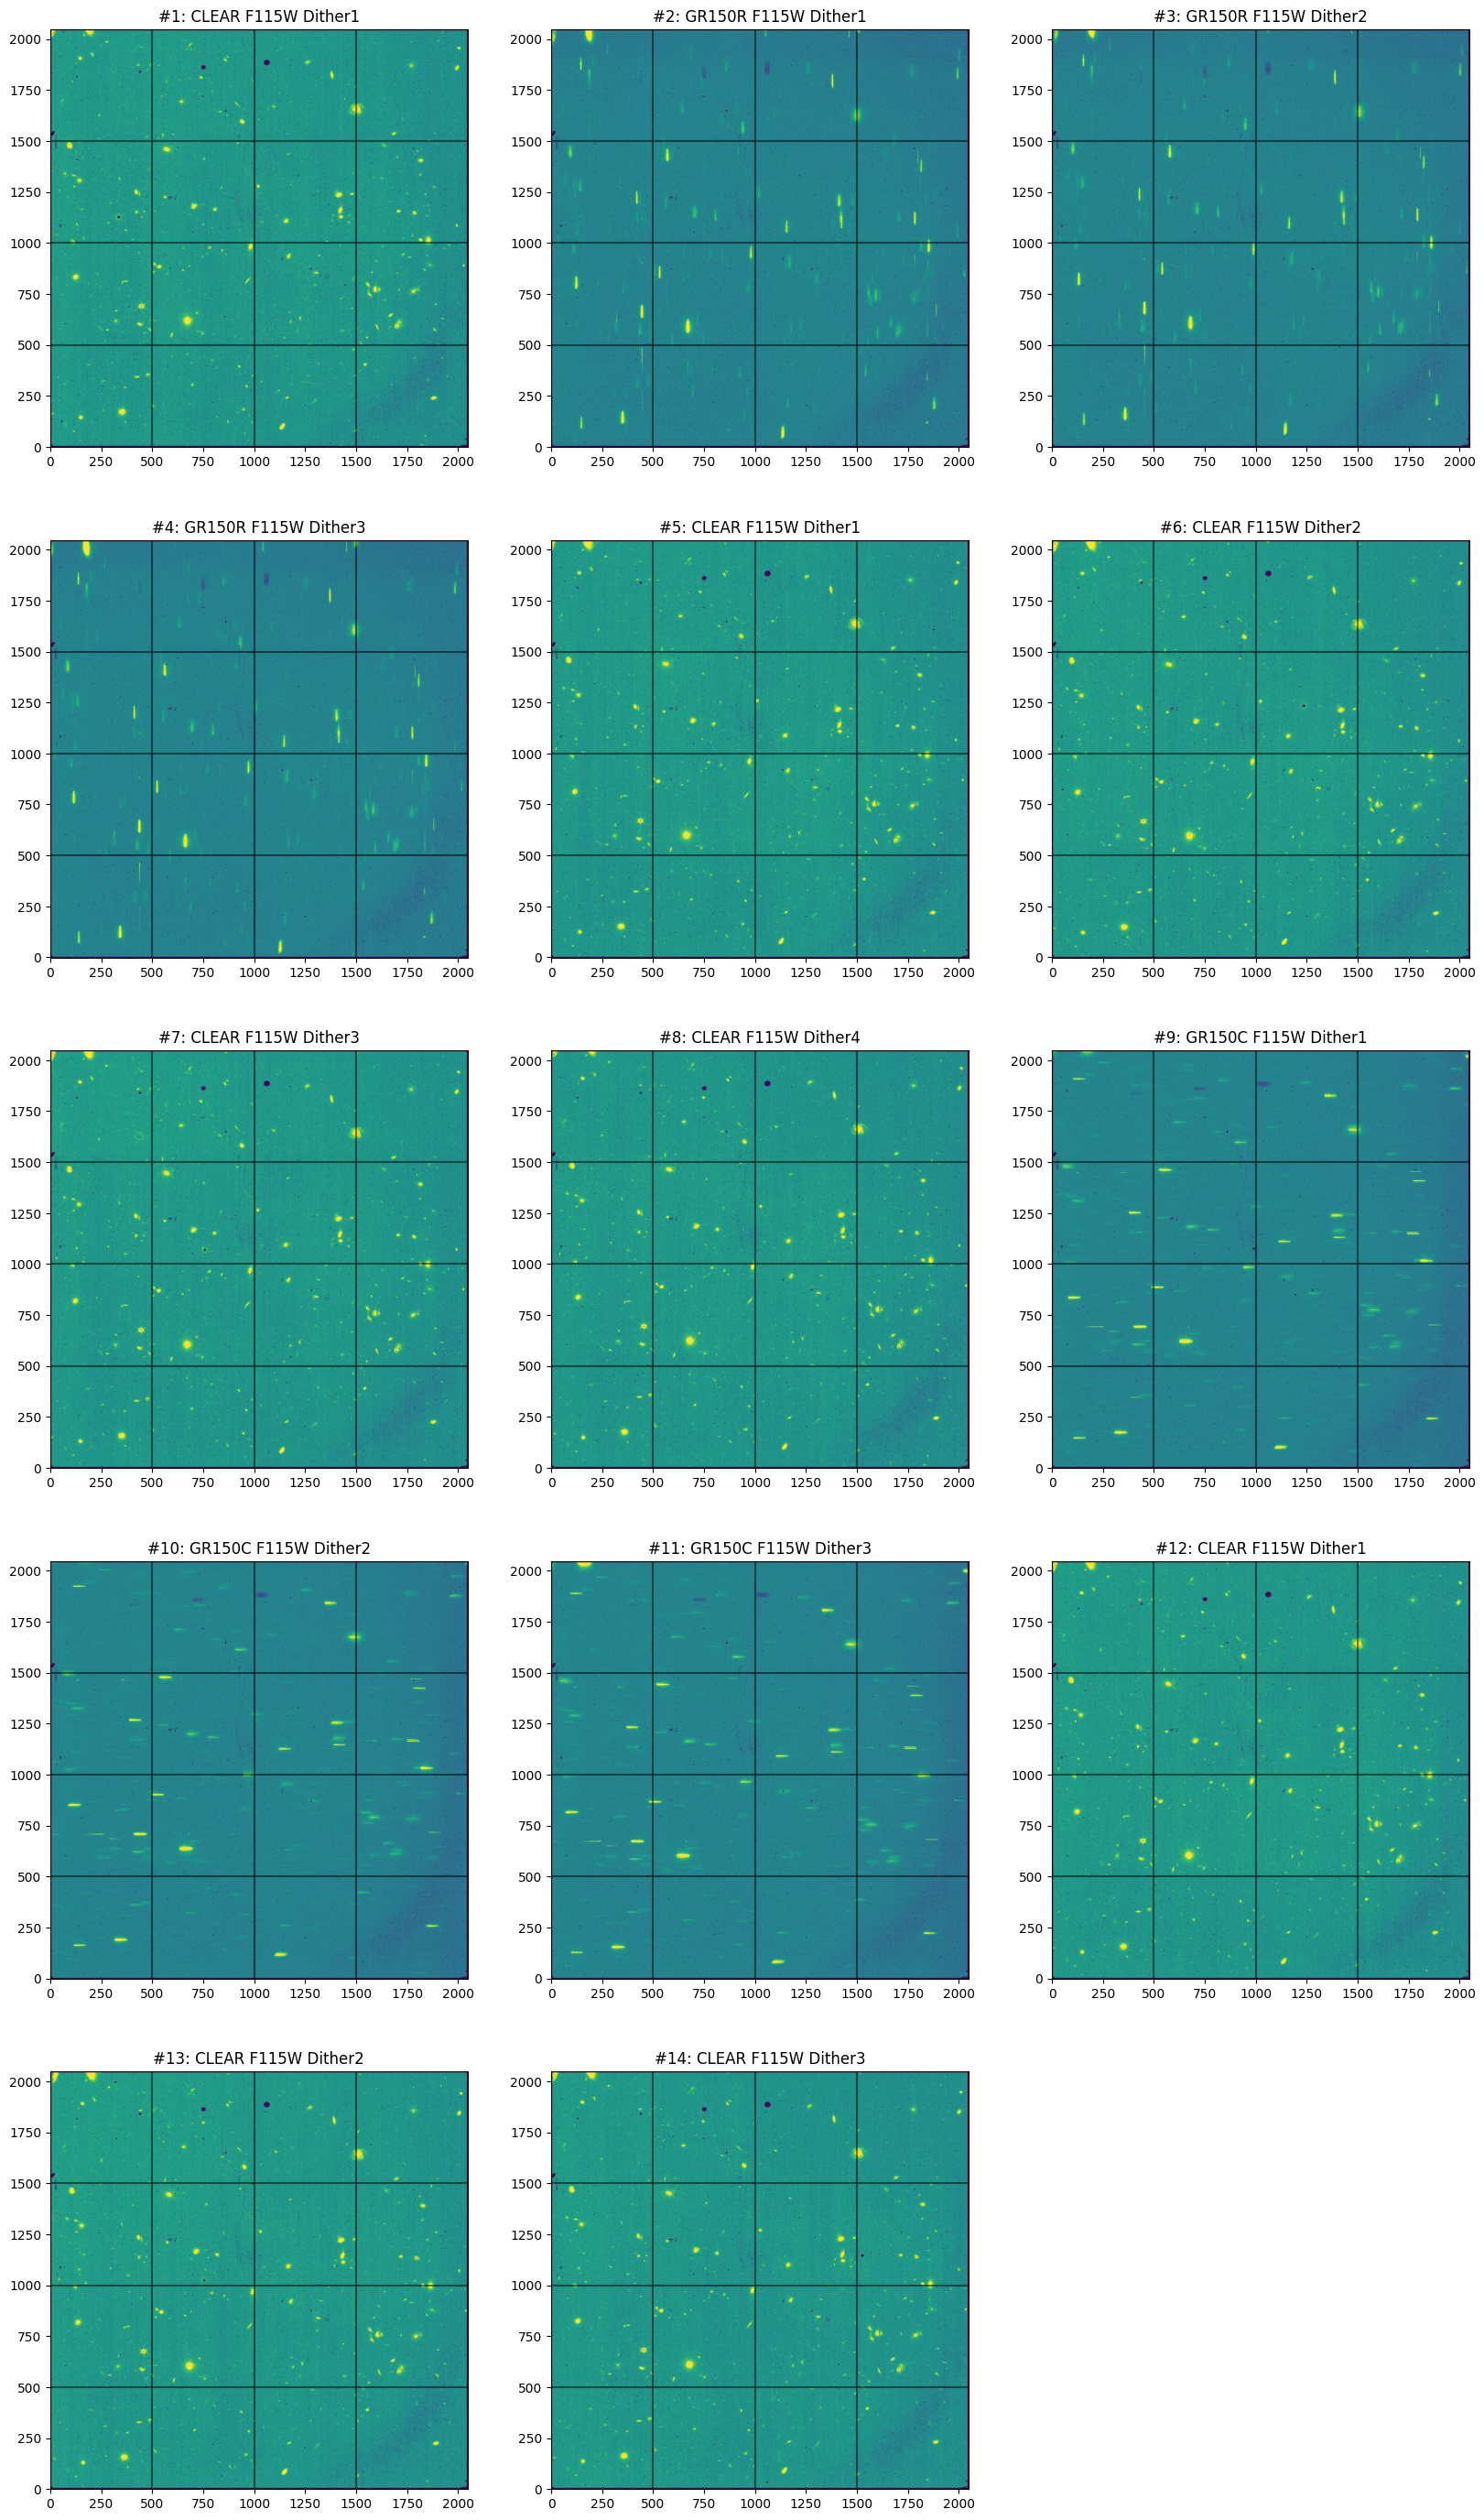

In [14]:
# plot set up
fig = plt.figure(figsize=(20, 35))
cols = 3
rows = int(np.ceil(14 / cols))

# loop over the first 14 rate files and plot them
for plt_num, rf in enumerate(rate_dfsort[0:14]['FILENAME']):

    # determine where the subplot should be
    xpos = (plt_num % 40) % cols
    ypos = ((plt_num % 40) // cols) # // to make it an int.

    # make the subplot
    ax = plt.subplot2grid((rows, cols), (ypos, xpos))

    # open the data and plot it
    with fits.open(rf) as hdu:
        data = hdu[1].data
        data[np.isnan(data)] = 0 # filling in nan data with 0s to help with the matplotlib color scale.
        
        ax.imshow(data, vmin=0, vmax=1.5, origin='lower')

        # adding in grid lines as a visual aid
        for gridline in [500, 1000, 1500]:
            ax.axhline(gridline, color='black', alpha=0.5)
            ax.axvline(gridline, color='black', alpha=0.5)

        ax.set_title(f"#{plt_num+1}: {hdu[0].header['FILTER']} {hdu[0].header['PUPIL']} Dither{hdu[0].header['PATT_NUM']}")

<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>